In [146]:
import os
from pathlib import Path
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime

local_dataset_name = "ohlc_stock"
base_data_dir = Path("/home/jovyan/data")
dataset_specific_base_path = base_data_dir / local_dataset_name
raw_data_target_dir = dataset_specific_base_path / "raw"
os.makedirs(raw_data_target_dir, exist_ok=True)
print(f"Raw dataset directory: {raw_data_target_dir}")

# Tickers and FRED codes
stock_tickers = ["SPY", "NVDA", "BBAI", "UNH", "INTC", "BA", "GLD"]
fred_symbols = {
    "federal_funds_rate": "FEDFUNDS",
    "unemployment_rate": "UNRATE",
    "cpi": "CPIAUCSL",
    "2y_treasury_yield": "DGS2",
    "10y_treasury_yield": "DGS10",
    "30y_treasury_yield": "DGS30",
    "m2_money_supply": "M2SL",
    "real_gdp": "GDPC1",
    "consumer_confidence_index": "UMCSENT",
}

start_date = "2000-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

def already_downloaded(ticker, directory):
    return (directory / f"{ticker}.csv").exists()

# Download stock OHLC data
for ticker in stock_tickers:
    target_file = raw_data_target_dir / f"{ticker}.csv"
    if already_downloaded(ticker, raw_data_target_dir):
        print(f"{ticker} data already exists, skipping...")
        continue
    print(f"Downloading {ticker} OHLC from Yahoo Finance...")
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    df.to_csv(target_file)
    print(f"Saved {ticker} to {target_file}")

# Download FRED macro features
for feature_name, fred_code in fred_symbols.items():
    target_file = raw_data_target_dir / f"{feature_name}.csv"
    if target_file.exists():
        print(f"{feature_name} data already exists, skipping...")
        continue
    print(f"Downloading {feature_name} ({fred_code}) from FRED...")
    df = pdr.DataReader(fred_code, 'fred', start_date, end_date)
    df.to_csv(target_file)
    print(f"Saved {feature_name} to {target_file}")

print("All data downloaded and stored in:", raw_data_target_dir)

# --- Cell 2: Import Libraries and Load Data ---

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
import cProfile # For basic profiling
import pstats # For processing profiling results
import io # For capturing profiling output
import gc
def reload_utils():
    import importlib
    import utils.etl
    import ohlc_stock.etl_chain
    import utils.eda
    import utils.eval
    import utils.models
    import utils.train
    import utils.submission

    importlib.reload(utils.etl)
    importlib.reload(ohlc_stock.etl_chain)
    importlib.reload(utils.eda)
    importlib.reload(utils.eval)
    importlib.reload(utils.train)
    importlib.reload(utils.models)
    importlib.reload(utils.submission)
    print("🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda,utils.train, utils.models, utils.eval, utils.submission")
# raw_data_target_dir = dataset_specific_base_path / "test"
# print(f"Listing files in {raw_data_target_dir}:")
try:
    for root, dirs, files in os.walk(raw_data_target_dir):
        level = root.replace(str(raw_data_target_dir), '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')
except FileNotFoundError:
    print(f"Error: Directory not found: {raw_data_target_dir}. Please ensure the dataset was downloaded and copied correctly.")
    # Exit or handle the error appropriately if the directory is not found

dfs = {}  # Store DataFrames by name
csv_files = list(raw_data_target_dir.glob("*.csv"))
for csv_file in csv_files:
    print(f"\n{'='*50}\nFile: {csv_file.name}")
    try:
        df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
        dfs[csv_file.stem] = df
        # Print DataFrame shape
        print(f"Shape: {df.shape}")
        # Print date range
        if df.index.dtype == 'datetime64[ns]' or pd.api.types.is_datetime64_any_dtype(df.index):
            print(f"Date range: {df.index.min()} -> {df.index.max()}")
        else:
            print("Index is not datetime, sample index:", df.index[:5])
        # Print columns
        print(f"Columns: {list(df.columns)}")
        # Print head
        print(df.head())
    except Exception as e:
        print("Could not load file:", e)


Raw dataset directory: /home/jovyan/data/ohlc_stock/raw
SPY data already exists, skipping...
NVDA data already exists, skipping...
BBAI data already exists, skipping...
UNH data already exists, skipping...
INTC data already exists, skipping...
BA data already exists, skipping...
GLD data already exists, skipping...
federal_funds_rate data already exists, skipping...
unemployment_rate data already exists, skipping...
cpi data already exists, skipping...
2y_treasury_yield data already exists, skipping...
10y_treasury_yield data already exists, skipping...
30y_treasury_yield data already exists, skipping...
m2_money_supply data already exists, skipping...
real_gdp data already exists, skipping...
consumer_confidence_index data already exists, skipping...
All data downloaded and stored in: /home/jovyan/data/ohlc_stock/raw
raw/
    10y_treasury_yield.csv
    2y_treasury_yield.csv
    30y_treasury_yield.csv
    BA.csv
    BBAI.csv
    consumer_confidence_index.csv
    cpi.csv
    federal_fun

/tmp/ipykernel_202/1095358540.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_202/1095358540.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_202/1095358540.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_202/1095358540.py:108: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ens

In [102]:
import pandas as pd
from pathlib import Path

def robust_load_csv(csv_file):
    try:
        df = pd.read_csv(csv_file)
    except Exception as e:
        print(f"Could not read {csv_file}: {e}")
        return None
    # Find the date column
    possible_date_cols = [c for c in df.columns if c.lower() in ('date', 'datetime')]
    if possible_date_cols:
        date_col = possible_date_cols[0]
    else:
        date_col = df.columns[0]  # fallback
    mask = pd.to_datetime(df[date_col], errors='coerce').notnull()
    df = df.loc[mask]
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    return df

# Paths & logic
raw_data_target_dir = Path("/home/jovyan/data/ohlc_stock/raw")
csv_files = list(raw_data_target_dir.glob("*.csv"))

tickers_all = ['SPY', 'NVDA', 'UNH', 'INTC', 'BA', 'GLD', 'BBAI']
tickers_phase1 = ['SPY', 'NVDA', 'UNH', 'INTC', 'BA', 'GLD']  # BBAI excluded

# Load all dataframes
dfs = {}
failed_to_load = []

for csv_file in csv_files:
    name = csv_file.stem.upper()
    df = robust_load_csv(csv_file)
    if df is None or df.empty:
        print(f"FAILED to load: {csv_file.name}")
        failed_to_load.append(name)
        continue
    dfs[name] = df

macro_keys = [k for k in dfs if k not in tickers_all]

macro_cols = [
    "CPIAUCSL",
    "M2SL",
    "FEDFUNDS",
    "GDPC1",
    "UNRATE",
    "UMCSENT",
]

def forward_fill_macros(df, macro_cols):
    to_fill = [col for col in macro_cols if col in df.columns]
    df[to_fill] = df[to_fill].ffill()
    return df

# Save processed DataFrames here
processed_dir = raw_data_target_dir.parent / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

for ticker in tickers_all:
    if ticker not in dfs:
        print(f"Ticker {ticker} missing, skipping.")
        continue
    # Merge ticker with macros
    merge_keys = [ticker] + macro_keys
    ticker_dfs = [dfs[k] for k in merge_keys if k in dfs]
    merged = pd.concat(ticker_dfs, axis=1, join="outer")
    merged = forward_fill_macros(merged, macro_cols)
    merged = merged.dropna()
    out_path = processed_dir / f"{ticker.lower()}_with_macro.parquet"
    merged.to_parquet(out_path)
    print(f"Saved {out_path} with shape {merged.shape}")



/tmp/ipykernel_202/3363151924.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mask = pd.to_datetime(df[date_col], errors='coerce').notnull()
/tmp/ipykernel_202/3363151924.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mask = pd.to_datetime(df[date_col], errors='coerce').notnull()
/tmp/ipykernel_202/3363151924.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mask = pd.to_datetime(df[date_col], errors='coerce').notnull()
/tmp/ipykernel_202/3363151924.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateut

Saved /home/jovyan/data/ohlc_stock/processed/spy_with_macro.parquet with shape (6340, 15)
Saved /home/jovyan/data/ohlc_stock/processed/nvda_with_macro.parquet with shape (6340, 15)
Saved /home/jovyan/data/ohlc_stock/processed/unh_with_macro.parquet with shape (6340, 15)
Saved /home/jovyan/data/ohlc_stock/processed/intc_with_macro.parquet with shape (6340, 15)
Saved /home/jovyan/data/ohlc_stock/processed/ba_with_macro.parquet with shape (6340, 15)
Saved /home/jovyan/data/ohlc_stock/processed/gld_with_macro.parquet with shape (5123, 15)
Saved /home/jovyan/data/ohlc_stock/processed/bbai_with_macro.parquet with shape (1033, 15)


In [103]:
import sys
sys.path.append(str(Path().resolve().parent))
reload_utils()
from utils.eval import display_system_memory_info
display_system_memory_info("System memory currently")

🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission

--- System memory currently ---
  System Total RAM:     15864.33 MB (15.49 GB)
  System Available RAM: 9411.14 MB (9.19 GB)
  System RAM Used (%):  40.7%
--------------------------------------


In [104]:
# Assumption: normalized distribution of returns in next 30d
# Approach: Frequency vector per bin aggregated into histogram
# Loss function for prob vs prob: KL Divergence, Jensen-ShannonCross-Entropy, Earth Mover’s Distance, L2/L1
# y target: a vector of length num_bins e.g. [0.05, 0.10, 0.20, 0.40, 0.25] with bin0: >5%, bin1: 4-5%...

import pandas as pd
from pathlib import Path

EXP_TICKER = "spy"
local_dataset_name = "ohlc_stock"
base_data_dir = Path("/home/jovyan/data")
dataset_specific_base_path = base_data_dir / local_dataset_name

experiment_ticker_path = dataset_specific_base_path / "processed" / f"{EXP_TICKER.lower()}_with_macro.parquet"
df = pd.read_parquet(experiment_ticker_path)
print(f"DF for {EXP_TICKER} loaded! Shape: {df.shape}")

import numpy as np
bin_edges = [
    float('-inf'), -0.15, -0.12, 
    -0.10,-0.09, -0.08,-0.07, -0.06, -0.05, -0.04, -0.03, -0.02, -0.01,
    0.0,
    0.01, 0.02, 0.03, 0.04, 0.05, 0.06,0.07, 0.08, 0.09,0.10,
    0.12, 0.15,
    float('inf')
]
num_bins = len(bin_edges) - 1
bin_labels = [f'bin{i}' for i in range(num_bins)]
def calc_y_target(df, price_col='Adj Close', horizon=30, bin_edges=bin_edges):
    y_target_list = []
    returns_arr = df[price_col].values
    for i in range(len(df)):
        if len(returns_arr) - i > horizon:
            future_prices = returns_arr[i+1 : i+1+horizon]
        else: future_prices = []
        # Defensive: skip if <30day data collection
        if len(future_prices) == 0:
            y_target_list.append(np.full(num_bins, np.nan))
            continue
        # Compute returns to current date
        returns = (future_prices - returns_arr[i]) / returns_arr[i]
        # Bin the returns
        freq, _ = np.histogram(returns, bins=bin_edges)
        # Normalize to sum to 1 (probability vector)
        freq = freq / freq.sum() if freq.sum() > 0 else np.full(num_bins, np.nan)
        y_target_list.append(freq)
    # Convert to DataFrame for easy inspection
    y_target_df = pd.DataFrame(y_target_list, index=df.index, columns=bin_labels)
    return y_target_df

# Usage:
ohlc_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
for col in ohlc_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
y_target_df = calc_y_target(df, price_col='Adj Close', horizon=30, bin_edges=bin_edges)
print(df.head)
print(y_target_df.head)
# # Attach to main DataFrame if you like:
# df_with_y = pd.concat([df, y_target_df], axis=1)

# # Example: show for one row
# print(df_with_y[['Adj Close'] + bin_labels].head(35))


DF for spy loaded! Shape: (6340, 15)
<bound method NDFrame.head of              Adj Close       Close        High         Low        Open  \
2000-01-03   92.414902  145.437500  148.250000  143.875000  148.250000   
2000-01-04   88.800919  139.750000  144.062500  139.640625  143.531250   
2000-01-05   88.959801  140.000000  141.531250  137.250000  139.937500   
2000-01-06   87.530067  137.750000  141.500000  137.750000  139.625000   
2000-01-07   92.613480  145.750000  145.750000  140.062500  140.312500   
...                ...         ...         ...         ...         ...   
2025-05-16  594.200012  594.200012  594.500000  589.280029  591.250000   
2025-05-19  594.849976  594.849976  595.539978  588.099976  588.099976   
2025-05-20  592.849976  592.849976  594.049988  589.599976  593.090027   
2025-05-21  582.859985  582.859985  592.580017  581.820007  588.440002   
2025-05-22  583.090027  583.090027  586.619995  581.409973  582.659973   

              Volume  DGS10  DGS2  DGS30  UM

In [105]:
# df.describe()
df.columns
# df.dtypes
# df.isna().sum()
# df.loc[df.duplicated()]
# df.duplicated().sum()
# 0 duplicated rows
# df.loc[df.duplicated(subset=['citric acid'])].head(5)
# df = df.loc[~df.duplicated(subset=['citric acid'])] \
#     .reset_index(drop=True).copy()
# df.shape
# df.head()
# df["HomePlanet"].unique()
# for col in df.columns:
#     print(col, df[col].dtype, df[col][0:3])
y_target_df.columns

Index(['bin0', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8',
       'bin9', 'bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15', 'bin16',
       'bin17', 'bin18', 'bin19', 'bin20', 'bin21', 'bin22', 'bin23', 'bin24',
       'bin25'],
      dtype='object')

In [106]:
n_before = df.shape[0]
n_after = df.dropna().shape[0]
print(f"🧮 {n_after}/{n_before} rows would remain after {n_after - n_before} rows dropna ({100 * n_after/n_before:.2f}%)")

🧮 6340/6340 rows would remain after 0 rows dropna (100.00%)


/tmp/ipykernel_202/3454988260.py:80: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')  # Red-Yellow-Green


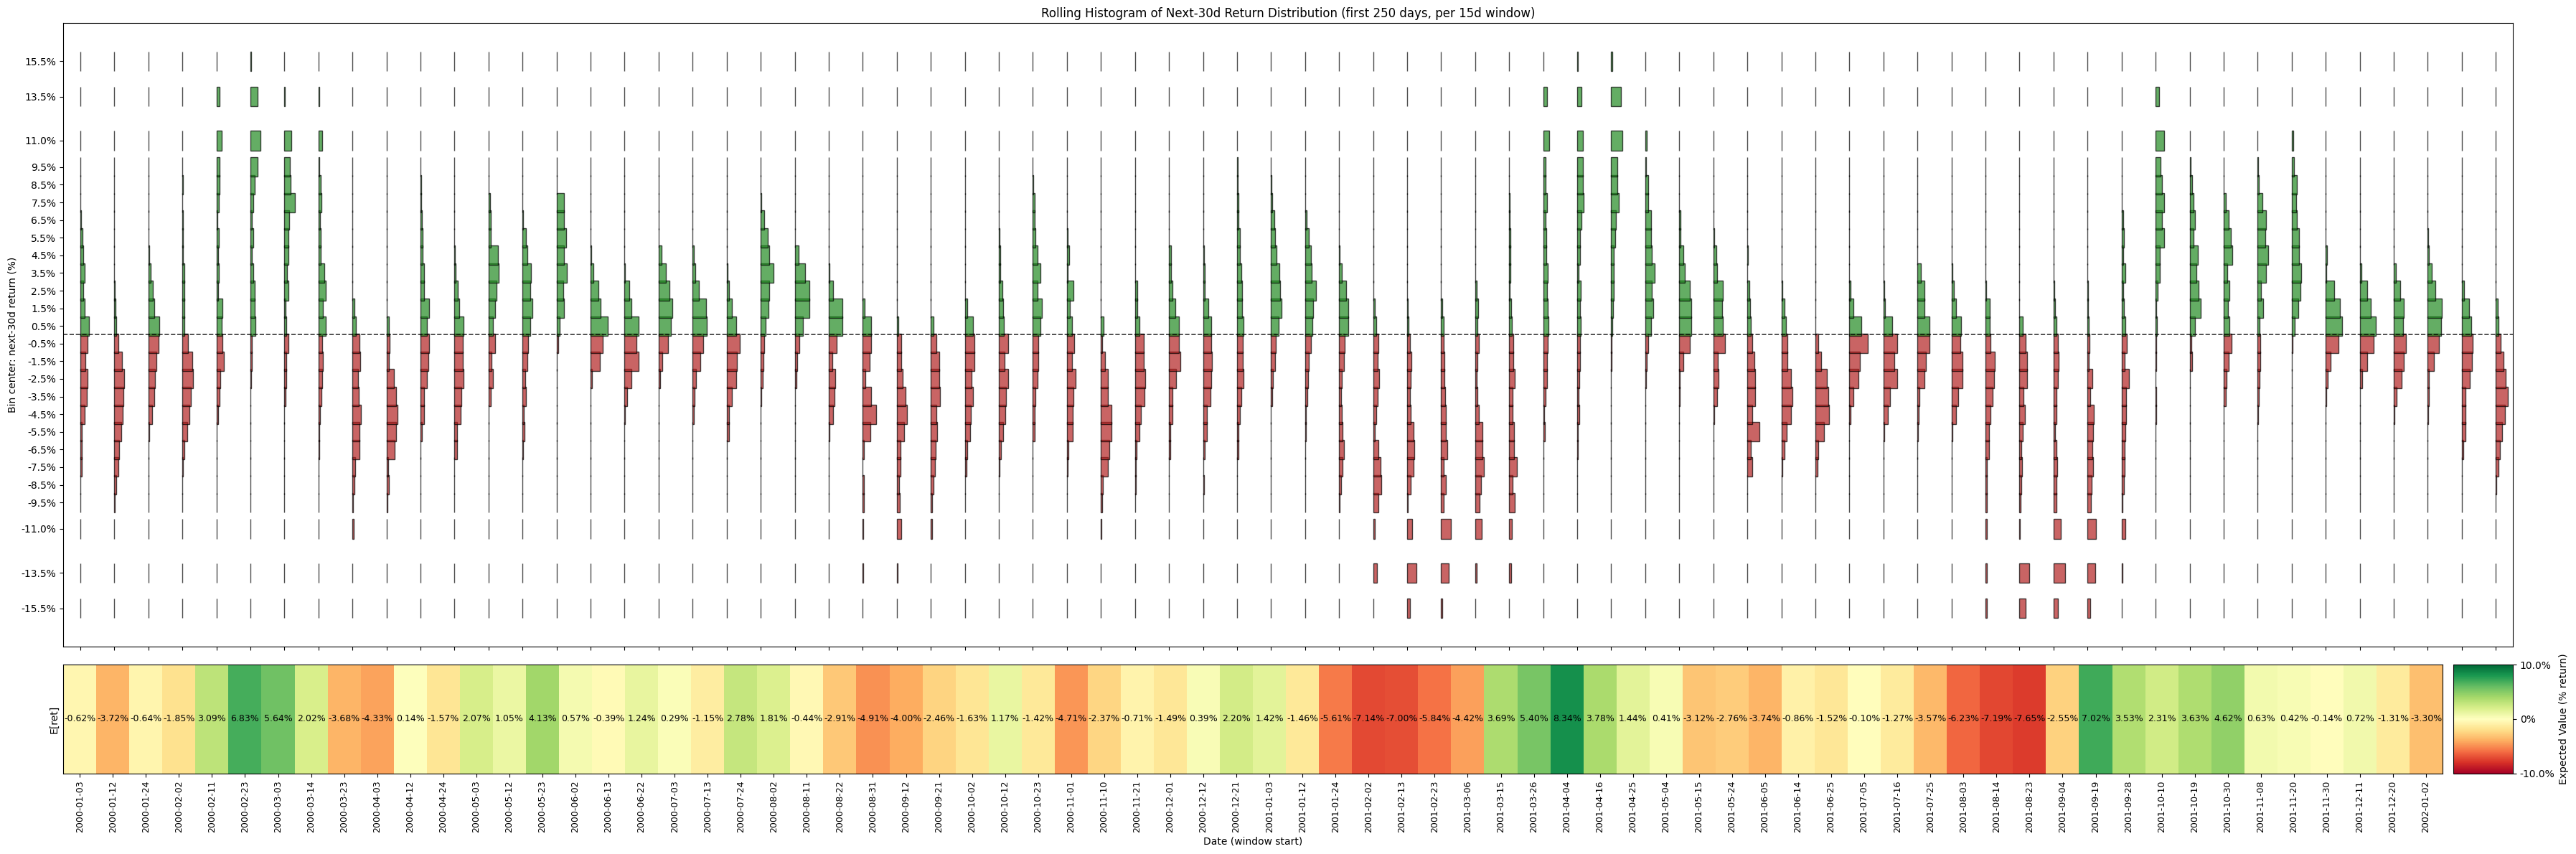

In [107]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

X_STEP = 7
FIRST_ROW_TO_GRAPH = 500

# Calculate bin centers
bin_centers = []
for i in range(len(bin_edges)-1):
    if np.isinf(bin_edges[i]):
        left = bin_edges[i+1] - 0.01
    else:
        left = bin_edges[i]
    if np.isinf(bin_edges[i+1]):
        right = bin_edges[i] + 0.01
    else:
        right = bin_edges[i+1]
    bin_centers.append(0.5 * (left + right))

step = X_STEP
y_target_short = y_target_df.iloc[:FIRST_ROW_TO_GRAPH]
dates = y_target_short.index
window_dates = [str(dates[i].date()) for i in range(0, len(dates), step)]

histograms = []
expected_vals = []
for i in range(0, len(y_target_short), step):
    window = y_target_short.iloc[i:i+step]
    hist = window.mean(axis=0)
    histograms.append(hist.values)
    exp_val = np.dot(hist.values, bin_centers)
    expected_vals.append(exp_val)
histograms = np.array(histograms)
expected_vals = np.array(expected_vals)

num_windows = histograms.shape[0]
x = np.arange(num_windows)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(max(12, num_windows//2), 12), 
    gridspec_kw={"height_ratios": [4, 0.7]}, sharex=True
)

# Histogram row (top)
colors = []
for c in bin_centers:
    if c < 0:
        colors.append('firebrick')
    elif c == 0:
        colors.append('gray')
    else:
        colors.append('forestgreen')

bar_height = (bin_centers[1] - bin_centers[0]) * 0.55
width_scale = 1.8

for i in range(num_windows):
    ax1.barh(
        y=bin_centers,
        width=histograms[i, :] * width_scale,
        left=i,
        height=bar_height,
        color=colors,
        alpha=0.7,
        edgecolor='k'
    )

ax1.set_ylabel('Bin center: next-30d return (%)')
ax1.set_title("Rolling Histogram of Next-30d Return Distribution (first 250 days, per 15d window)")
ax1.set_yticks(bin_centers)
ax1.set_yticklabels([f"{c*100:.1f}%" for c in bin_centers])
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.8, zorder=1)
ax1.set_xlim(-0.5, num_windows - 0.5)

# Expected value row (bottom)
# Set range for colormap (e.g., from -10% to +10%)
vmin, vmax = -0.1, 0.1
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = plt.cm.get_cmap('RdYlGn')  # Red-Yellow-Green

for i in range(num_windows):
    ev = expected_vals[i]
    color = cmap(norm(ev)) if not np.isnan(ev) else 'lightgray'
    rect = ax2.bar(i, 1, color=color, width=1.0, edgecolor='none')
    # Show value as a percent, if enough space
    if not np.isnan(ev):
        ax2.text(i, 0.5, f"{ev*100:.2f}%", va='center', ha='center', fontsize=9, color='black')

ax2.set_yticks([])
ax2.set_ylabel("E[ret]")
ax2.set_xlim(-0.5, num_windows - 0.5)
ax2.set_ylim(0, 1)
ax2.set_xticks(x)
ax2.set_xticklabels(window_dates, rotation=90, fontsize=9)
ax2.set_xlabel('Date (window start)')

# Add colorbar as legend for expected value
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='2.5%', pad=0.15)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Expected Value (% return)')
cbar.set_ticks([vmin, 0, vmax])
cbar.set_ticklabels([f"{vmin*100:.1f}%", "0%", f"{vmax*100:.1f}%"])

plt.tight_layout()
plt.show()


In [108]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# 1. Setup bin centers
bin_centers = []
for i in range(len(bin_edges)-1):
    if np.isinf(bin_edges[i]):
        left = bin_edges[i+1] - 0.01
    else:
        left = bin_edges[i]
    if np.isinf(bin_edges[i+1]):
        right = bin_edges[i] + 0.01
    else:
        right = bin_edges[i+1]
    bin_centers.append(0.5 * (left + right))
bin_centers = np.array(bin_centers)
bin_labels = [f'bin{i}' for i in range(len(bin_centers))]

# 2. Compute rolling moments
def ytarget_rolling_moments(y_bins, bin_centers, window):
    vals = y_bins.values
    index = y_bins.index
    means, medians, skews, kurts = [], [], [], []
    for i in range(len(y_bins)):
        start = max(0, i-window)
        arrs = vals[start:i]  # use only the prior days
        if arrs.shape[0] == 0:
            means.append(np.nan)
            medians.append(np.nan)
            skews.append(np.nan)
            kurts.append(np.nan)
            continue
        weighted_means = arrs @ bin_centers
        means.append(np.mean(weighted_means))
        # Weighted median
        def weighted_median(p):
            cdf = np.cumsum(p)
            return bin_centers[np.searchsorted(cdf, 0.5)]
        medians.append(np.median([weighted_median(p) for p in arrs]))
        # Skew and kurtosis using samples
        samples = [np.random.choice(bin_centers, p=(p/p.sum() if p.sum() > 0 else None), size=100) for p in arrs]
        all_samples = np.concatenate(samples) if len(samples) else np.array([np.nan])
        skews.append(skew(all_samples))
        kurts.append(kurtosis(all_samples))
    return pd.DataFrame({
        f'y_mean_prev{window}d': means,
        f'y_median_prev{window}d': medians,
        f'y_skew_prev{window}d': skews,
        f'y_kurtosis_prev{window}d': kurts,
    }, index=index)

# Compute and join
for window in [30, 40, 50]:
    moments = ytarget_rolling_moments(y_target_df, bin_centers, window)
    df = df.join(moments)
print(df.columns)
print(y_target_df)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'DGS10', 'DGS2',
       'DGS30', 'UMCSENT', 'CPIAUCSL', 'FEDFUNDS', 'M2SL', 'GDPC1', 'UNRATE',
       'y_mean_prev30d', 'y_median_prev30d', 'y_skew_prev30d',
       'y_kurtosis_prev30d', 'y_mean_prev40d', 'y_median_prev40d',
       'y_skew_prev40d', 'y_kurtosis_prev40d', 'y_mean_prev50d',
       'y_median_prev50d', 'y_skew_prev50d', 'y_kurtosis_prev50d'],
      dtype='object')
            bin0  bin1  bin2  bin3  bin4      bin5      bin6      bin7  \
2000-01-03   0.0   0.0   0.0   0.0   0.0  0.000000  0.033333  0.033333   
2000-01-04   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.000000   
2000-01-05   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.000000   
2000-01-06   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.000000   
2000-01-07   0.0   0.0   0.0   0.0   0.0  0.066667  0.033333  0.033333   
...          ...   ...   ...   ...   ...       ...       ...       ...   
2025-05-16   NaN   NaN   NaN   NaN   NaN

In [109]:
print(df.columns)
print(y_target_df)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'DGS10', 'DGS2',
       'DGS30', 'UMCSENT', 'CPIAUCSL', 'FEDFUNDS', 'M2SL', 'GDPC1', 'UNRATE',
       'y_mean_prev30d', 'y_median_prev30d', 'y_skew_prev30d',
       'y_kurtosis_prev30d', 'y_mean_prev40d', 'y_median_prev40d',
       'y_skew_prev40d', 'y_kurtosis_prev40d', 'y_mean_prev50d',
       'y_median_prev50d', 'y_skew_prev50d', 'y_kurtosis_prev50d'],
      dtype='object')
            bin0  bin1  bin2  bin3  bin4      bin5      bin6      bin7  \
2000-01-03   0.0   0.0   0.0   0.0   0.0  0.000000  0.033333  0.033333   
2000-01-04   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.000000   
2000-01-05   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.000000   
2000-01-06   0.0   0.0   0.0   0.0   0.0  0.000000  0.000000  0.000000   
2000-01-07   0.0   0.0   0.0   0.0   0.0  0.066667  0.033333  0.033333   
...          ...   ...   ...   ...   ...       ...       ...       ...   
2025-05-16   NaN   NaN   NaN   NaN   NaN

In [110]:
macro_cols = [
    "CPIAUCSL",
    "M2SL",
    "DGS30",
    "FEDFUNDS",
    "GDPC1",
    "UNRATE",
    "DGS10",
    "DGS2",
    "UMCSENT",
]

for macro in macro_cols:
    df[f"{macro}_diff_to_30d_ma"] = (df[macro] - df[macro].rolling(30, min_periods=1).mean())
    df[f"{macro}_diff_to_200d_ma"] = df[macro] - df[macro].rolling(200, min_periods=1).mean()
    df[f"{macro}_ratio_to_30d_ma"] = (df[macro] - df[macro].rolling(30, min_periods=1).mean())/df[macro]
    df[f"{macro}_ratio_to_200d_ma"] = (df[macro] - df[macro].rolling(200, min_periods=1).mean())/df[macro]


In [111]:
print(df.columns)
print(y_target_df.columns)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'DGS10', 'DGS2',
       'DGS30', 'UMCSENT', 'CPIAUCSL', 'FEDFUNDS', 'M2SL', 'GDPC1', 'UNRATE',
       'y_mean_prev30d', 'y_median_prev30d', 'y_skew_prev30d',
       'y_kurtosis_prev30d', 'y_mean_prev40d', 'y_median_prev40d',
       'y_skew_prev40d', 'y_kurtosis_prev40d', 'y_mean_prev50d',
       'y_median_prev50d', 'y_skew_prev50d', 'y_kurtosis_prev50d',
       'CPIAUCSL_diff_to_30d_ma', 'CPIAUCSL_diff_to_200d_ma',
       'CPIAUCSL_ratio_to_30d_ma', 'CPIAUCSL_ratio_to_200d_ma',
       'M2SL_diff_to_30d_ma', 'M2SL_diff_to_200d_ma', 'M2SL_ratio_to_30d_ma',
       'M2SL_ratio_to_200d_ma', 'DGS30_diff_to_30d_ma',
       'DGS30_diff_to_200d_ma', 'DGS30_ratio_to_30d_ma',
       'DGS30_ratio_to_200d_ma', 'FEDFUNDS_diff_to_30d_ma',
       'FEDFUNDS_diff_to_200d_ma', 'FEDFUNDS_ratio_to_30d_ma',
       'FEDFUNDS_ratio_to_200d_ma', 'GDPC1_diff_to_30d_ma',
       'GDPC1_diff_to_200d_ma', 'GDPC1_ratio_to_30d_ma',
       'GDPC1_ratio_to_2

In [112]:
# Assuming df has columns: 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'
import pandas as pd

# Typical windows
short_ma = 10
long_ma = 50

# Moving Averages
df['close_sma_10'] = df['Adj Close'].rolling(short_ma).mean()
df['close_sma_50'] = df['Adj Close'].rolling(long_ma).mean()
df['close_ema_10'] = df['Adj Close'].ewm(span=10, adjust=False).mean()
df['close_ema_50'] = df['Adj Close'].ewm(span=50, adjust=False).mean()

# Rate of Change and Momentum
df['roc_10'] = df['Adj Close'].pct_change(periods=10)
df['momentum_10'] = df['Adj Close'] - df['Adj Close'].shift(10)

# Volatility
df['close_rolling_std_10'] = df['Adj Close'].rolling(10).std()

print(df.dtypes)
# True Range and ATR
df['prev_close'] = df['Adj Close'].shift(1)
df['tr'] = df[['High', 'prev_close']].max(axis=1) - df[['Low', 'prev_close']].min(axis=1)
df['atr_14'] = df['tr'].rolling(14).mean()

# RSI (14)
delta = df['Adj Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / (avg_loss + 1e-9)  # Prevent division by zero
df['rsi_14'] = 100 - (100 / (1 + rs))

# MACD (12/26), signal line (9)
ema12 = df['Adj Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Bollinger Bands (20, 2 std)
df['bb_mid'] = df['Adj Close'].rolling(20).mean()
df['bb_std'] = df['Adj Close'].rolling(20).std()
df['bb_upper'] = df['bb_mid'] + 2*df['bb_std']
df['bb_lower'] = df['bb_mid'] - 2*df['bb_std']

# Volume z-score
df['volume_z_20'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()

# Drop helper columns if not needed
df = df.drop(columns=['prev_close', 'tr'], errors='ignore')


Adj Close               float64
Close                   float64
High                    float64
Low                     float64
Open                    float64
                         ...   
close_ema_10            float64
close_ema_50            float64
roc_10                  float64
momentum_10             float64
close_rolling_std_10    float64
Length: 70, dtype: object


In [113]:
print(df.columns)
print(df.isna().sum())
print(y_target_df.columns)
print(y_target_df.isna().sum())


# Merge on date index
merged = df.join(y_target_df, how='inner')

# Drop rows with any NaN
merged = merged.dropna()

# Drop the original columns you specified
drop_cols = [
    'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'CPIAUCSL',
    'M2SL', 'DGS30', 'FEDFUNDS', 'GDPC1', 'UNRATE', 'DGS10', 'DGS2',
    'UMCSENT'
]
# Drop only if present
merged = merged.drop(columns=[c for c in drop_cols if c in merged.columns])

print("Final merged shape:", merged.shape)
print( merged.columns)
print( merged.isna().sum())

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'DGS10', 'DGS2',
       'DGS30', 'UMCSENT', 'CPIAUCSL', 'FEDFUNDS', 'M2SL', 'GDPC1', 'UNRATE',
       'y_mean_prev30d', 'y_median_prev30d', 'y_skew_prev30d',
       'y_kurtosis_prev30d', 'y_mean_prev40d', 'y_median_prev40d',
       'y_skew_prev40d', 'y_kurtosis_prev40d', 'y_mean_prev50d',
       'y_median_prev50d', 'y_skew_prev50d', 'y_kurtosis_prev50d',
       'CPIAUCSL_diff_to_30d_ma', 'CPIAUCSL_diff_to_200d_ma',
       'CPIAUCSL_ratio_to_30d_ma', 'CPIAUCSL_ratio_to_200d_ma',
       'M2SL_diff_to_30d_ma', 'M2SL_diff_to_200d_ma', 'M2SL_ratio_to_30d_ma',
       'M2SL_ratio_to_200d_ma', 'DGS30_diff_to_30d_ma',
       'DGS30_diff_to_200d_ma', 'DGS30_ratio_to_30d_ma',
       'DGS30_ratio_to_200d_ma', 'FEDFUNDS_diff_to_30d_ma',
       'FEDFUNDS_diff_to_200d_ma', 'FEDFUNDS_ratio_to_30d_ma',
       'FEDFUNDS_ratio_to_200d_ma', 'GDPC1_diff_to_30d_ma',
       'GDPC1_diff_to_200d_ma', 'GDPC1_ratio_to_30d_ma',
       'GDPC1_ratio_to_2

In [114]:
# Assumption: normalized distribution of returns in next 30d
# Approach: Frequency vector per bin aggregated into histogram
# Loss function for prob vs prob: KL Divergence, Jensen-ShannonCross-Entropy, Earth Mover’s Distance, L2/L1
# y target: a vector of length num_bins e.g. [0.05, 0.10, 0.20, 0.40, 0.25] with bin0: >5%, bin1: 4-5%...

import numpy as np
import sklearn.metrics
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

# Probability-based metrics
def kl_divergence(y_true, y_pred):
    # Add small epsilon to avoid log(0)
    eps = 1e-9
    y_true = np.clip(y_true, eps, 1)
    y_pred = np.clip(y_pred, eps, 1)
    return np.mean([entropy(y_t, y_p) for y_t, y_p in zip(y_true, y_pred)])

def js_divergence(y_true, y_pred):
    # Jensen-Shannon is symmetric and bounded
    return np.mean([jensenshannon(y_t, y_p) ** 2 for y_t, y_p in zip(y_true, y_pred)])  # squared = actual JS div

def cross_entropy_loss(y_true, y_pred):
    # Add small epsilon to avoid log(0)
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1)
    return -np.mean([np.sum(y_t * np.log(y_p)) for y_t, y_p in zip(y_true, y_pred)])

def l2_loss(y_true, y_pred):
    return np.mean([np.sum((y_t - y_p) ** 2) for y_t, y_p in zip(y_true, y_pred)])

def l1_loss(y_true, y_pred):
    return np.mean([np.sum(np.abs(y_t - y_p)) for y_t, y_p in zip(y_true, y_pred)])

def earth_movers_distance(y_true, y_pred, bin_centers=None):
    # This expects true and pred to be [n_samples, n_bins], and bin_centers to be [n_bins]
    if bin_centers is None:
        raise ValueError("Must provide bin_centers for Earth Mover's Distance")
    # Compute EMD for each pair
    emds = []
    for yt, yp in zip(y_true, y_pred):
        # Convert prob dist to sample dist over bin centers
        emds.append(wasserstein_distance(bin_centers, bin_centers, u_weights=yt, v_weights=yp))
    return np.mean(emds)

# Map of string -> (metric name, metric function)
metric_lookup = {
    "kl_divergence": ("KL Divergence", kl_divergence),
    "js_divergence": ("Jensen-Shannon Divergence", js_divergence),
    "cross_entropy": ("Cross-Entropy", cross_entropy_loss),
    "l2": ("L2 Loss", l2_loss),
    "l1": ("L1 Loss", l1_loss),
    # EMD needs bin_centers, so we handle that separately
}

perf_eval_metric = "kl_divergence"  # Or "js_divergence", "cross_entropy", "l2", "l1"

if perf_eval_metric not in metric_lookup:
    raise ValueError(f"Unsupported metric: {perf_eval_metric}")

eval_metric_name, eval_metric_fn = metric_lookup[perf_eval_metric]
print(f"✅ Evaluation metric set to: {eval_metric_name}")

# Example of usage:
# Suppose y_true and y_pred are both (n_samples, n_bins)
# y_true = merged[[f'bin{i}' for i in range(num_bins)]].values
# y_pred = model.predict(X)  # shape: (n_samples, n_bins)

# metric_value = eval_metric_fn(y_true, y_pred)


✅ Evaluation metric set to: KL Divergence


In [115]:
# === Domain knowledge ===
# Any semantic/description of features?
# PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
# HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
# CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
# Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
# Destination - The planet the passenger will be debarking to.
# Age - The age of the passenger.
# VIP - Whether the passenger has paid for special VIP service during the voyage.
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
# Name - The first and last names of the passenger.
# Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [116]:
# from utils.eda import eda_vis
# # === prelim EDA on raw dataset ===
# eda_vis(X, y, task_type)
# reload_utils()
# from utils.eda import feature_eda_vis
# # === deep EDA for features on ETL-applied dataset ===
# feature_eda_vis(X, y, task_type)

In [16]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np
# from scipy import stats
# from statsmodels.stats.proportion import proportion_confint

# # Assume X and y are pandas DataFrames/Series as described by the user.
# # For demonstration, let's create some sample data if X and y are not defined
# # (Remove or comment this out if you have your actual X and y)
# if 'X' not in locals() or 'y' not in locals():
#     print("Generating sample X and y for demonstration purposes...")
#     n_samples = 200
#     X_data = {
#         'HomePlanet': np.random.choice(['Earth', 'Europa', 'Mars', 'PlanetX', 'PlanetY'], size=n_samples), # Added more categories
#         'CryoSleep': np.random.choice([True, False, np.nan], size=n_samples, p=[0.25, 0.7, 0.05]), # Added NaNs
#         'Age': np.random.normal(loc=30, scale=10, size=n_samples).clip(0, 80),
#         'RoomService': np.random.exponential(scale=100, size=n_samples).clip(0, 2000) * np.random.choice([0,1, np.nan], size=n_samples, p=[0.35,0.55, 0.1]), # Some zeros and NaNs
#         'VIP': np.random.choice([True, False, np.nan], size=n_samples, p=[0.05, 0.85, 0.1]) # With NaNs
#     }
#     X = pd.DataFrame(X_data)
#     X['Age'] = X['Age'].astype(float).fillna(X['Age'].median()).astype(int) # Handle potential NaNs from clip then fill
#     X['RoomService'] = X['RoomService'].astype(float)
    
#     # Simulate some dependency for y
#     y_score = X['Age'] * -0.1 + X['RoomService'].fillna(0) * 0.01 + \
#               (X['HomePlanet'] == 'Europa').astype(int) * 20 + \
#               X['CryoSleep'].fillna(False).astype(int) * 30 # Handle NaNs in CryoSleep for scoring
#     y_prob = 1 / (1 + np.exp(- (y_score - y_score.mean()) / y_score.std() )) # Sigmoid
#     y = pd.Series(np.random.binomial(1, y_prob, size=n_samples).astype(bool), name='Transported')


# # --- Data Preparation ---
# y_named = y.copy()
# if not hasattr(y_named, 'name') or y_named.name is None:
#     y_named.name = 'Transported' # Default name if y has no name

# df_combined = X.copy()
# df_combined['Transported_numeric'] = y_named.astype(int)

# CATEGORICAL_THRESHOLD = 20 
# palette = {0: 'skyblue', 1: 'salmon'} 
# legend_labels = {0: 'Not Transported', 1: 'Transported'}
# feature_columns = X.columns

# # --- Main Loop for Plotting ---
# for feature_col in feature_columns:
#     print(f"--- Analyzing Feature: {feature_col} ---")
    
#     fig, axes = plt.subplots(2, 3, figsize=(22, 13)) # Adjusted figsize slightly for better label spacing
#     fig.suptitle(f'Comprehensive Analysis: {feature_col} | Target: {y_named.name}', fontsize=18, y=0.99) # Adjusted y for suptitle
    
#     # --- Row 1: Distribution Visualizations ---
#     ax_1_1 = axes[0, 0]
#     try:
#         plot_data_1_1 = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#         if not plot_data_1_1.empty and plot_data_1_1[feature_col].nunique() > 0 :
#             sns.stripplot(data=plot_data_1_1, x=feature_col, y='Transported_numeric', hue='Transported_numeric',
#                           jitter=0.25, dodge=True, ax=ax_1_1, palette=palette, legend=False, alpha=0.6)
#             ax_1_1.set_title('Point Distribution by Target')
#             ax_1_1.set_ylabel(f'{y_named.name} (0=F, 1=T)')
#             ax_1_1.set_yticks([0, 1])
#             ax_1_1.set_yticklabels(['False', 'True'])
#             ax_1_1.set_xlabel(feature_col)
#             handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10) for i in palette]
#             ax_1_1.legend(handles, [legend_labels[i] for i in palette], title=y_named.name, loc='best')
            
#             # Rotate x-axis labels if needed
#             if plot_data_1_1[feature_col].nunique() > 5 and plot_data_1_1[feature_col].dtype == 'object': # More categories
#                  ax_1_1.tick_params(axis='x', rotation=45, labelbottom=True)
#                  plt.setp(ax_1_1.get_xticklabels(), ha="right", rotation_mode="anchor")
#             elif plot_data_1_1[feature_col].nunique() > 10 and plot_data_1_1[feature_col].dtype != 'object': # Numerical with many ticks
#                  ax_1_1.tick_params(axis='x', rotation=30, labelbottom=True)
#                  plt.setp(ax_1_1.get_xticklabels(), ha="right", rotation_mode="anchor")
#             else: # Fewer categories or numerical, no rotation or default handling
#                  ax_1_1.tick_params(axis='x', labelbottom=True)

#         else:
#             ax_1_1.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_1.transAxes)
#             ax_1_1.set_title('Point Distribution (No Data)')
#     except Exception as e:
#         ax_1_1.set_title('Point Distribution (Error)')
#         ax_1_1.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_1.transAxes, wrap=True)
#         print(f"  Error in Plot 1.1 for {feature_col}: {e}")

#     ax_1_2 = axes[0, 1]
#     try:
#         plot_data_1_2 = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#         if not plot_data_1_2.empty and plot_data_1_2[feature_col].nunique() > 0:
#             sns.histplot(data=plot_data_1_2, x=feature_col, hue='Transported_numeric', 
#                          multiple='layer', kde=False, ax=ax_1_2, palette=palette, 
#                          stat="density", common_norm=False, alpha=0.6, legend=True)
#             ax_1_2.set_title('Normalized Histogram by Target')
#             ax_1_2.set_xlabel(feature_col)
#             handles_hist, labels_hist = ax_1_2.get_legend_handles_labels()
#             try: 
#                 labels_hist_descriptive = [legend_labels[int(float(l))] for l in labels_hist]
#                 ax_1_2.legend(handles_hist, labels_hist_descriptive, title=y_named.name)
#             except (ValueError, KeyError): 
#                  ax_1_2.legend(title=y_named.name)
#         else:
#             ax_1_2.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_2.transAxes)
#             ax_1_2.set_title('Histogram (No Data)')
#     except Exception as e:
#         ax_1_2.set_title('Histogram (Error)')
#         ax_1_2.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_2.transAxes, wrap=True)
#         print(f"  Error in Plot 1.2 for {feature_col}: {e}")

#     ax_1_3 = axes[0, 2]
#     try:
#         temp_df_combined = df_combined.dropna(subset=[feature_col]) 
#         if not temp_df_combined.empty and temp_df_combined[feature_col].nunique() > 0:
#             is_categorical_like = temp_df_combined[feature_col].dtype == 'object' or \
#                                   temp_df_combined[feature_col].nunique() < CATEGORICAL_THRESHOLD
            
#             target_0_data = temp_df_combined[temp_df_combined['Transported_numeric'] == 0][feature_col]
#             target_1_data = temp_df_combined[temp_df_combined['Transported_numeric'] == 1][feature_col]

#             if not target_0_data.empty and not target_1_data.empty:
#                 if is_categorical_like:
#                     props_0 = target_0_data.value_counts(normalize=True)
#                     props_1 = target_1_data.value_counts(normalize=True)
#                     all_categories = sorted(list(set(props_0.index) | set(props_1.index)))
#                     props_0 = props_0.reindex(all_categories, fill_value=0)
#                     props_1 = props_1.reindex(all_categories, fill_value=0)
#                     diff_props = props_1 - props_0
#                     diff_props.plot(kind='bar', ax=ax_1_3, color=['tomato' if x < 0 else 'mediumseagreen' for x in diff_props.values]) # Removed rot here
#                     ax_1_3.tick_params(axis='x', rotation=45) # Apply rotation
#                     plt.setp(ax_1_3.get_xticklabels(), ha='right', rotation_mode='anchor') # Ensure alignment
#                     ax_1_3.set_ylabel('Prop(Y=1) - Prop(Y=0)')
#                 else: 
#                     min_val = min(target_0_data.min(), target_1_data.min())
#                     max_val = max(target_0_data.max(), target_1_data.max())
#                     if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val: # Handle NaN or single value case
#                         bins = np.array([temp_df_combined[feature_col].min() - 0.5, temp_df_combined[feature_col].max() + 0.5]) if temp_df_combined[feature_col].nunique() > 0 else np.array([0,1])
#                     else: 
#                         bins = np.linspace(min_val, max_val, 11)
#                     hist_0, _ = np.histogram(target_0_data.dropna(), bins=bins, density=True) # dropna within histogram
#                     hist_1, _ = np.histogram(target_1_data.dropna(), bins=bins, density=True) # dropna within histogram
#                     diff_hist = hist_1 - hist_0
#                     bin_centers = (bins[:-1] + bins[1:]) / 2
#                     bar_width = bins[1] - bins[0] if len(bins) > 1 else 1
#                     ax_1_3.bar(bin_centers, diff_hist, width=bar_width * 0.9, 
#                                 color=['tomato' if x < 0 else 'mediumseagreen' for x in diff_hist])
#                     ax_1_3.set_ylabel('Density(Y=1) - Density(Y=0)')
#                 ax_1_3.axhline(0, color='black', lw=0.8, linestyle='--')
#                 ax_1_3.set_title('Outcome Difference by Feature Value')
#                 ax_1_3.set_xlabel(feature_col)
#             else:
#                 ax_1_3.text(0.5, 0.5, "Not enough data in one/both target groups", ha='center', va='center', transform=ax_1_3.transAxes)
#                 ax_1_3.set_title('Outcome Difference (Not enough data)')
#         else:
#             ax_1_3.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_3.transAxes)
#             ax_1_3.set_title('Outcome Difference (No Data)')
#     except Exception as e:
#         ax_1_3.set_title('Outcome Difference (Error)')
#         ax_1_3.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_3.transAxes, wrap=True)
#         print(f"  Error in Plot 1.3 for {feature_col}: {e}")

#     # --- Row 2: Statistical Significance ---
#     ax_2_1 = axes[1, 0] 
#     ax_2_2 = axes[1, 1] 
#     ax_2_3 = axes[1, 2] 

#     for ax_text in [ax_2_2, ax_2_3]:
#         ax_text.clear()
#         ax_text.axis('off')

#     current_feature_data = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#     if current_feature_data.empty or current_feature_data[feature_col].nunique() == 0: # Also check for no variance
#         ax_2_1.text(0.5, 0.5, "No data or no variance\nfor stats after NaN drop", ha='center', va='center', transform=ax_2_1.transAxes)
#         ax_2_1.set_title('Stats (No Data)')
#         ax_2_2.text(0.05, 0.9, "No data or no variance for stats after NaN drop.", fontsize=9, va='top', wrap=True)
#         ax_2_3.text(0.05, 0.9, "No data or no variance for stats after NaN drop.", fontsize=9, va='top', wrap=True)
#         fig.subplots_adjust(hspace=0.6, wspace=0.35, top=0.93, bottom=0.08, left=0.05, right=0.97)
#         plt.show()
#         continue 

#     is_categorical_feature = current_feature_data[feature_col].dtype == 'object' or \
#                              current_feature_data[feature_col].nunique() < CATEGORICAL_THRESHOLD
    
#     stats_summary_text = ""
#     interpretation_text = ""

#     if is_categorical_feature:
#         ax_2_1.set_title(f'Proportion Transported by {feature_col}\n(with 95% CIs)')
#         # Ensure feature_col is treated as string for crosstab if it's not already object (e.g. boolean, int categories)
#         contingency_table = pd.crosstab(current_feature_data[feature_col].astype(str), current_feature_data['Transported_numeric'])
        
#         if contingency_table.shape[0] < 1 or contingency_table.shape[1] < 2 : # Need at least 1 category and 2 outcome classes
#             stats_summary_text += "Chi-squared test not applicable (table too small or one outcome class missing).\n"
#             ax_2_1.text(0.5,0.5, "Too few categories or\noutcomes for plot/test", ha='center', va='center', transform=ax_2_1.transAxes)
#         elif contingency_table.shape[0] < 2: # Need at least 2 categories for chi2
#              stats_summary_text += "Chi-squared test not applicable (needs at least 2 categories).\n"
#              ax_2_1.text(0.5,0.5, "Needs at least 2 categories for Chi2 test", ha='center', va='center', transform=ax_2_1.transAxes)
#         else:
#             chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency_table)
#             stats_summary_text += f"Chi-squared Test of Independence:\n"
#             stats_summary_text += f"  Chi2 Stat: {chi2:.2f}, P-value: {p_chi2:.3g}\n  DOF: {dof}\n"
#             interpretation_text += f"P-value ({p_chi2:.3g}) for Chi-squared test: "
#             interpretation_text += "Suggests " + ("a significant" if p_chi2 < 0.05 else "no significant") + \
#                                    f" association between {feature_col} and {y_named.name}.\n\n"

#             categories = contingency_table.index
#             proportions_transported = []
#             ci_lows = []
#             ci_highs = []
            
#             for cat in categories:
#                 count_transported = contingency_table.loc[cat, 1] if 1 in contingency_table.columns else 0
#                 count_not_transported = contingency_table.loc[cat, 0] if 0 in contingency_table.columns else 0
#                 n_obs_cat = count_transported + count_not_transported
#                 if n_obs_cat > 0:
#                     prop = count_transported / n_obs_cat
#                     low, high = proportion_confint(count_transported, n_obs_cat, method='wilson')
#                     proportions_transported.append(prop)
#                     ci_lows.append(low)
#                     ci_highs.append(high)
#                 else: 
#                     proportions_transported.append(0)
#                     ci_lows.append(0)
#                     ci_highs.append(0)

#             prop_df = pd.DataFrame({
#                 'category': categories, # Already strings due to .astype(str) in crosstab
#                 'proportion_transported': proportions_transported,
#                 'ci_low': ci_lows,
#                 'ci_high': ci_highs
#             })
            
#             ax_2_1.bar(prop_df['category'], prop_df['proportion_transported'], 
#                        yerr=[prop_df['proportion_transported'] - prop_df['ci_low'], prop_df['ci_high'] - prop_df['proportion_transported']],
#                        capsize=5, color='mediumseagreen', alpha=0.7)
#             ax_2_1.set_ylabel(f'Proportion {y_named.name}')
#             ax_2_1.tick_params(axis='x', rotation=45) # Corrected: Apply rotation
#             plt.setp(ax_2_1.get_xticklabels(), ha='right', rotation_mode='anchor') # Corrected: Ensure alignment
#             ax_2_1.axhline(current_feature_data['Transported_numeric'].mean(), color='grey', linestyle='--', label='Overall Mean')
#             if not prop_df.empty: # Only add legend if there's data to plot
#                 ax_2_1.legend(loc='best')

#             interpretation_text += "Error bars on plot show 95% CIs for proportion transported. "
#             interpretation_text += "If CIs for different categories don't overlap much, "
#             interpretation_text += "it suggests a significant difference in transport rates.\n"

#     else: # Numerical feature
#         group0 = current_feature_data[current_feature_data['Transported_numeric'] == 0][feature_col].dropna() # Ensure NaNs are out for tests
#         group1 = current_feature_data[current_feature_data['Transported_numeric'] == 1][feature_col].dropna() # Ensure NaNs are out for tests

#         ax_2_1.set_title(f'{feature_col} Distribution by Target')
#         # For boxplot, ensure data passed has NaNs handled if seaborn version is older
#         sns.boxplot(x='Transported_numeric', y=feature_col, data=current_feature_data.dropna(subset=[feature_col]), 
#                     ax=ax_2_1, palette=palette, hue='Transported_numeric', legend=False)
#         ax_2_1.set_xticklabels([legend_labels[0], legend_labels[1]])
#         ax_2_1.set_xlabel(y_named.name)

#         stats_summary_text += "Normality (Shapiro-Wilk):\n"
#         norm_p0, norm_p1 = -1.0, -1.0 # Initialize as float
#         if len(group0) >=3 : 
#             shapiro_stat0, norm_p0 = stats.shapiro(group0)
#             stats_summary_text += f"  Group 0 (Not Transported): p={norm_p0:.3g}\n"
#         else: stats_summary_text += "  Group 0: Too few samples for normality test.\n"
#         if len(group1) >=3 :
#             shapiro_stat1, norm_p1 = stats.shapiro(group1)
#             stats_summary_text += f"  Group 1 (Transported): p={norm_p1:.3g}\n"
#         else: stats_summary_text += "  Group 1: Too few samples for normality test.\n"
        
#         # Default to Mann-Whitney U if any group has < 3 samples for normality, or if normality fails
#         use_ttest = (norm_p0 > 0.05 or len(group0) < 3) and \
#                     (norm_p1 > 0.05 or len(group1) < 3)

#         if use_ttest and len(group0)>1 and len(group1)>1:
#             levene_stat, levene_p = stats.levene(group0, group1)
#             stats_summary_text += f"Homogeneity of Variances (Levene's test): p={levene_p:.3g}\n"
#             equal_var = levene_p > 0.05

#             t_stat, p_ttest = stats.ttest_ind(group0, group1, equal_var=equal_var) # nan_policy='omit' is default in newer scipy
#             stats_summary_text += f"Independent T-test (equal_var={equal_var}):\n"
#             stats_summary_text += f"  T-statistic: {t_stat:.2f}, P-value: {p_ttest:.3g}\n"
#             interpretation_text += f"P-value ({p_ttest:.3g}) from t-test: "
#             interpretation_text += "Suggests " + ("a significant" if p_ttest < 0.05 else "no significant") + \
#                                    f" difference in mean {feature_col} between groups.\n"
#             ax_2_1.text(0.5, 0.95, f"T-test p-value: {p_ttest:.3g}", ha='center', va='top', transform=ax_2_1.transAxes, fontsize=9, color='red', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

#         elif len(group0)>0 and len(group1)>0: 
#             try:
#                 u_stat, p_mannwhitney = stats.mannwhitneyu(group0, group1, alternative='two-sided') # nan_policy='omit' is default
#                 stats_summary_text += f"Mann-Whitney U Test:\n"
#                 stats_summary_text += f"  U-statistic: {u_stat:.0f}, P-value: {p_mannwhitney:.3g}\n"
#                 interpretation_text += f"P-value ({p_mannwhitney:.3g}) from Mann-Whitney U test: "
#                 interpretation_text += "Suggests " + ("a significant" if p_mannwhitney < 0.05 else "no significant") + \
#                                    f" difference in distributions of {feature_col} between groups.\n"
#                 ax_2_1.text(0.5, 0.95, f"Mann-Whitney p: {p_mannwhitney:.3g}", ha='center', va='top', transform=ax_2_1.transAxes, fontsize=9, color='red', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
#             except ValueError as e_mw: 
#                  stats_summary_text += f"Mann-Whitney U Test: Error - {e_mw}\n"
#                  interpretation_text += "Mann-Whitney U test could not be performed (e.g., identical data in groups).\n"
#         else:
#             stats_summary_text += "Not enough data in one or both groups for numerical tests.\n"
#             interpretation_text += "Not enough data to compare groups statistically.\n"

#     interpretation_text += "\nBayesian Perspective:\nA Bayesian approach could provide posterior distributions for parameters "
#     interpretation_text += "(e.g., difference in means/proportions). This offers a richer view of uncertainty "
#     interpretation_text += "and allows direct probability statements about the effect size, rather than just a p-value."

#     ax_2_2.text(0.01, 0.98, stats_summary_text, fontsize=8, va='top', ha='left', wrap=True, family='monospace') # Reduced font size
#     ax_2_2.set_title("Statistical Test Details", fontsize=10)
    
#     ax_2_3.text(0.01, 0.98, interpretation_text, fontsize=8, va='top', ha='left', wrap=True) # Reduced font size
#     ax_2_3.set_title("Interpretation & Bayesian Note", fontsize=10)

#     fig.subplots_adjust(hspace=0.7, wspace=0.4, top=0.93, bottom=0.12, left=0.06, right=0.97) # Adjusted spacing
#     plt.show()

# print("--- Finished generating all plots. ---")


In [117]:
import pandas as pd

# If not already defined, here are your bin labels:
bin_labels = [f'bin{i}' for i in range(num_bins)]

# Extract X and y from merged
X = merged.drop(columns=bin_labels)
y = merged[bin_labels]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Sample X columns:", X.shape)
print("Sample y (first row):", y.shape)


X shape: (6261, 64)
y shape: (6261, 26)
Sample X columns: (6261, 64)
Sample y (first row): (6261, 26)


In [118]:
task_type = "prob_vector"

In [119]:
reload_utils()
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from utils.train import train_sklearn_model, train_nn_model, log_model_artifact, log_final_metrics, evaluate_model
# Import XGBoost if available
try:
    from xgboost import XGBRegressor
    xgboost_available = True
except ImportError:
    xgboost_available = False
    print("XGBoost not installed! Install with `pip install xgboost` to use XGBRegressor.")

# --- 1. Split data into train/val (80%/20%, no shuffle for time series)
X = merged.drop(columns=bin_labels)
y = merged[bin_labels]

test_size = 0.2
split_index = int(len(X) * (1 - test_size))
X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

# --- 2. Random Forest Regressor (multioutput)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
trained_rf, y_pred_rf = train_sklearn_model(
    rf_model, X_train, y_train, X_val, y_val, task_type="prob_vector"
)

# Ensure valid probabilities
y_pred_rf = np.clip(y_pred_rf, 0, None)
y_pred_rf = y_pred_rf / (y_pred_rf.sum(axis=1, keepdims=True) + 1e-9)

print("Random Forest y_pred_rf shape:", y_pred_rf.shape)

# --- 3. XGBoost Regressor (multioutput)
if xgboost_available:
    xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, tree_method="hist")
    trained_xgb, y_pred_xgb = train_sklearn_model(
        xgb_model, X_train, y_train, X_val, y_val, task_type="prob_vector"
    )
    y_pred_xgb = np.clip(y_pred_xgb, 0, None)
    y_pred_xgb = y_pred_xgb / (y_pred_xgb.sum(axis=1, keepdims=True) + 1e-9)
    print("XGBoost y_pred_xgb shape:", y_pred_xgb.shape)
else:
    y_pred_xgb = None

print("Ready for evaluation.")


🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission
Train shape: (5008, 64), Validation shape: (1253, 64)
Random Forest y_pred_rf shape: (1253, 26)
XGBoost y_pred_xgb shape: (1253, 26)
Predictions saved! Ready for evaluation.


In [138]:

import pandas as pd
import numpy as np

def convert_array_to_df(data_array: np.ndarray, columns=None, index=None) -> pd.DataFrame:
    if isinstance(data_array, pd.DataFrame):
        return data_array
    if not isinstance(data_array, np.ndarray):
        raise TypeError("Input 'data_array' must be a NumPy array.")
    if data_array.ndim == 1:
        data_array = data_array.reshape(1, -1) # Reshape 1D array to a single row
    num_cols = data_array.shape[1]
    if columns is None:
        columns = [f'bin_{i}' for i in range(num_cols)]
    elif len(columns) != num_cols:
        raise ValueError(
            f"Number of provided columns ({len(columns)}) "
            f"does not match the array's number of columns ({num_cols})."
        )
    df = pd.DataFrame(data_array, columns=columns, index=index)
    return df
y_pred_xgb = convert_array_to_df(y_pred_xgb)
y_pred_rf = convert_array_to_df(y_pred_rf)
y_val = convert_array_to_df(y_val)



/tmp/ipykernel_202/2889594217.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust right boundary to prevent colorbar overlap


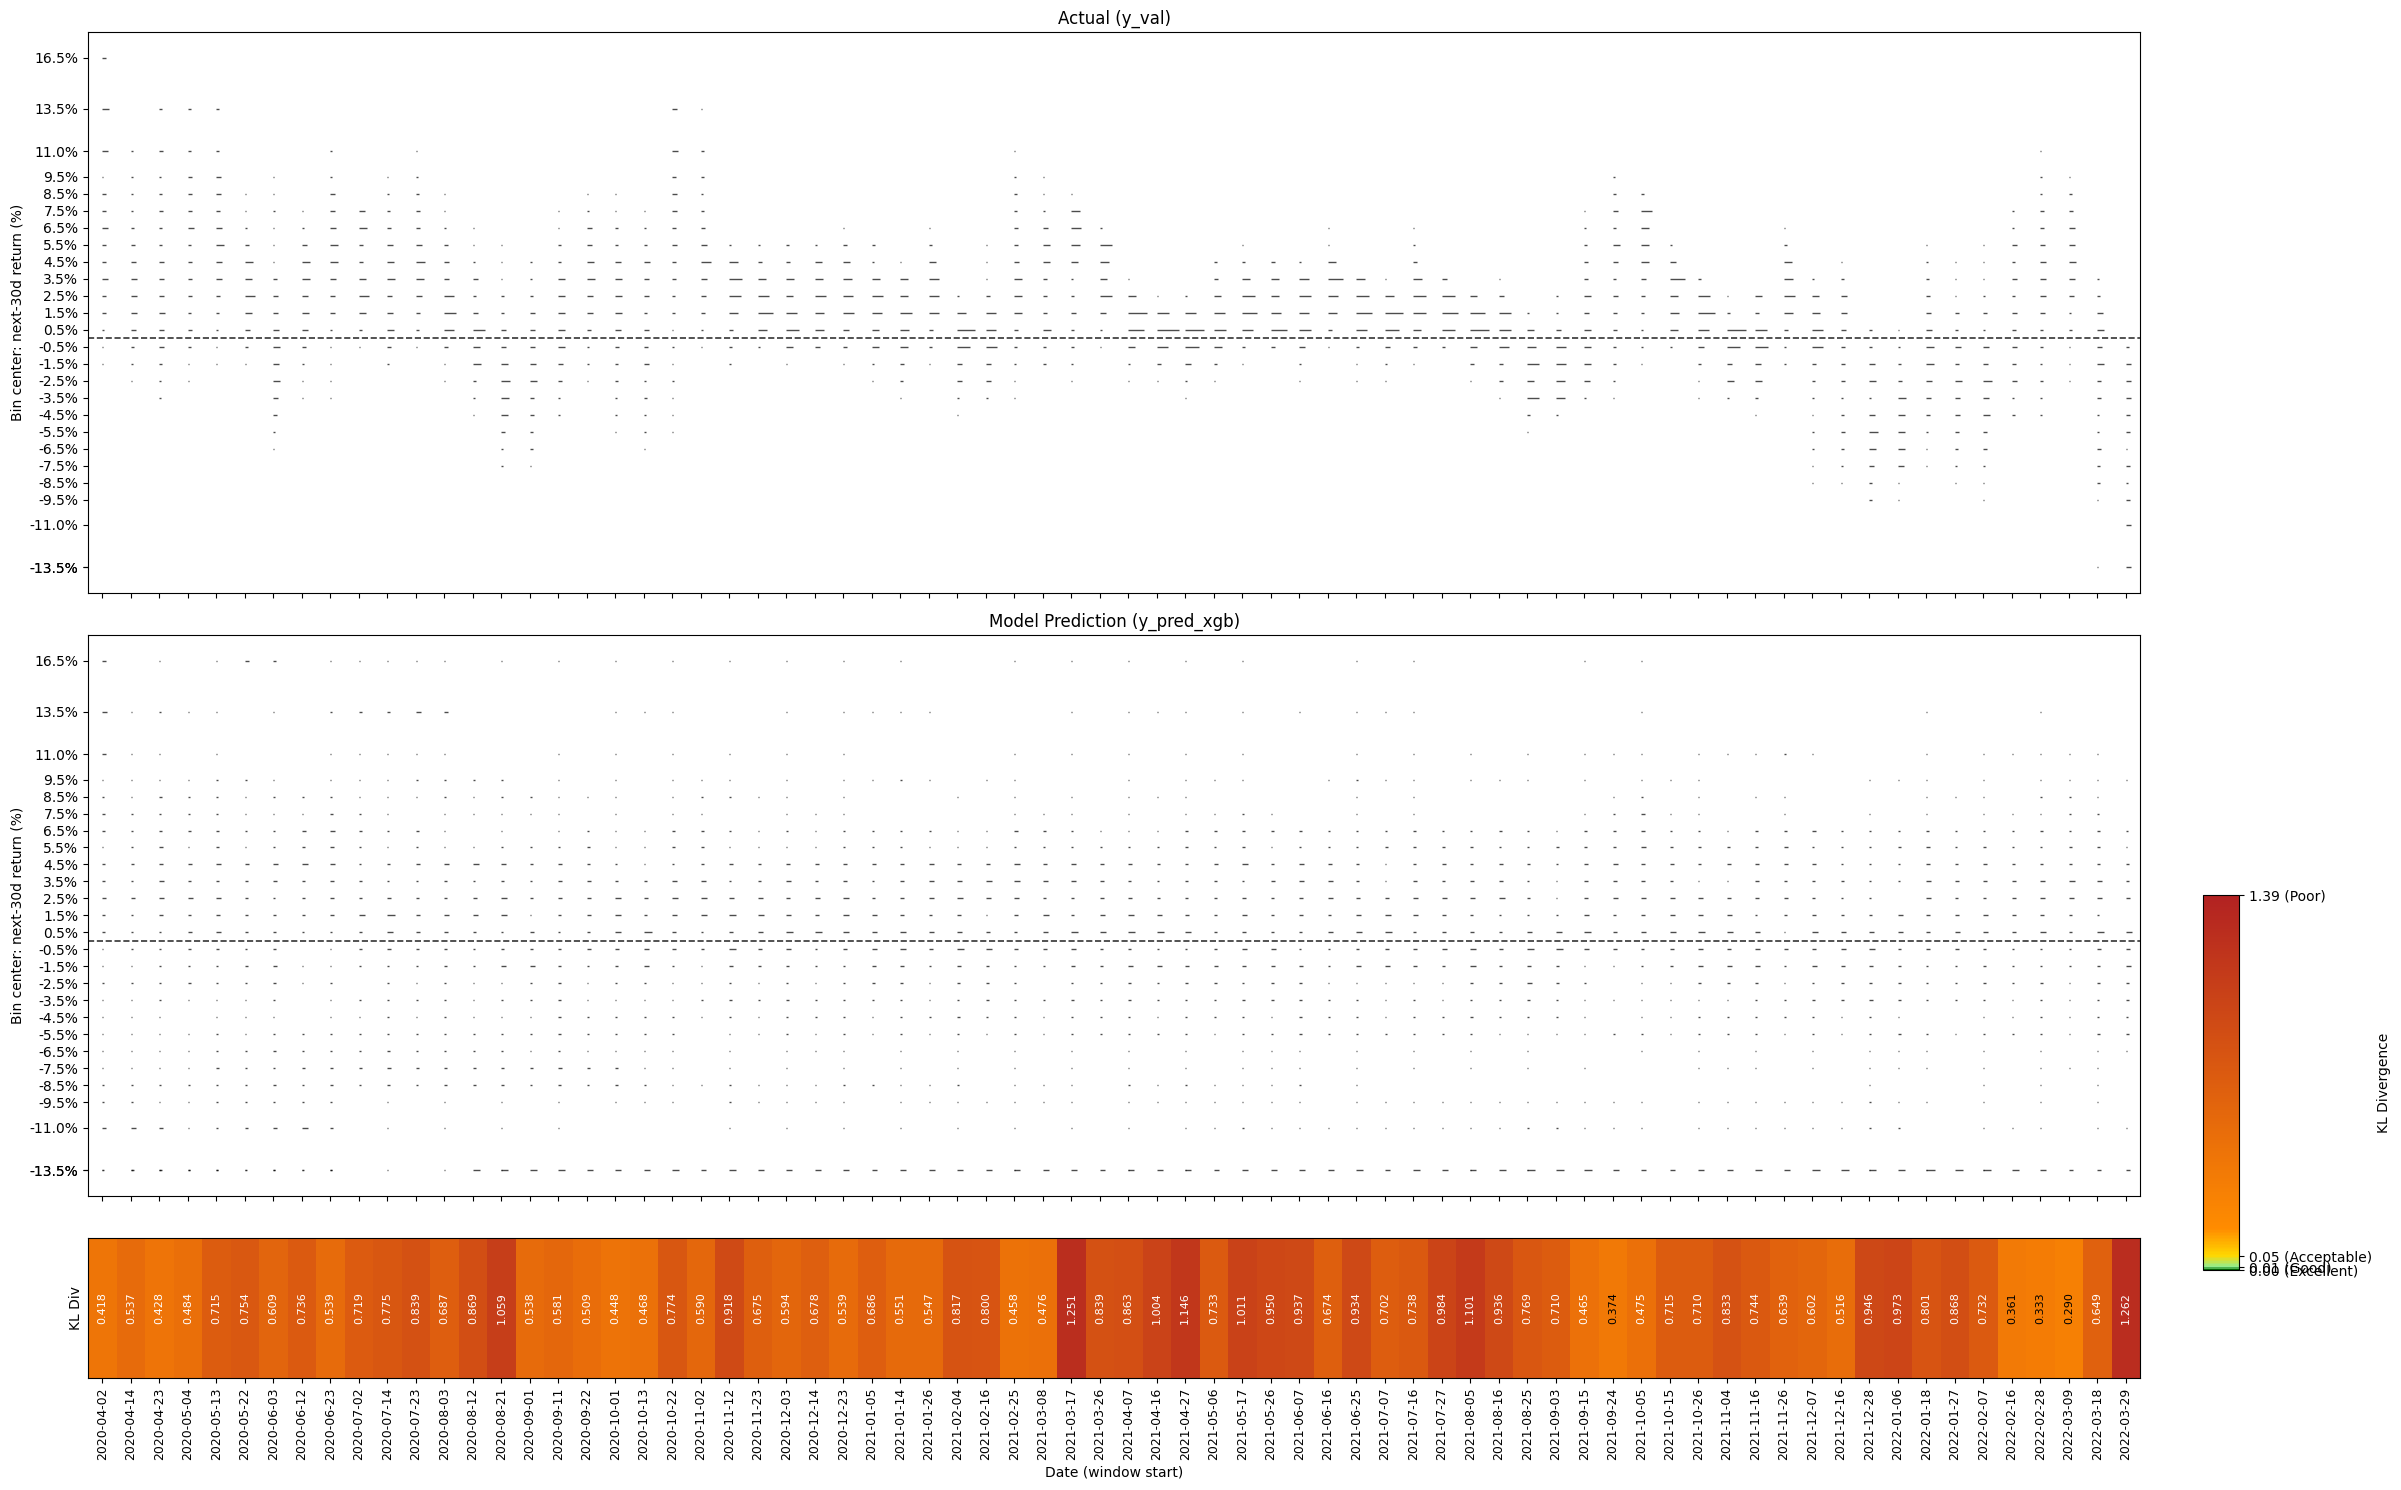

In [139]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import entropy

X_STEP = 7
FIRST_ROW_TO_GRAPH = 500

bin_centers = []
for i in range(len(bin_edges) - 1):
    lower_bound = bin_edges[i]
    upper_bound = bin_edges[i+1]

    if np.isinf(lower_bound) and np.isinf(upper_bound):
        center = 0 # Fallback, should not happen with typical bin_edges
    elif np.isinf(lower_bound):
        center = upper_bound - (upper_bound - bin_edges[i+2]) / 2 if i+2 < len(bin_edges) else upper_bound - 0.01
    elif np.isinf(upper_bound):
        center = lower_bound + (lower_bound - bin_edges[i-1]) / 2 if i-1 >= 0 else lower_bound + 0.01
    else:
        center = 0.5 * (lower_bound + upper_bound)
    bin_centers.append(center)
bin_centers = np.array(bin_centers)


# Actual (y_target)
step = X_STEP
y_target_short = y_val.iloc[:FIRST_ROW_TO_GRAPH]
dates = y_target_short.index
window_dates = [str(dates[i].date()) for i in range(0, len(dates), step)]
histograms_true = []
for i in range(0, len(y_target_short), step):
    window = y_target_short.iloc[i:i+step]
    hist = window.mean(axis=0)
    histograms_true.append(hist.values)
histograms_true = np.array(histograms_true)

# RF predicted (now correctly sourced from y_pred_xgb)
y_pred_rf = y_pred_rf.iloc[:FIRST_ROW_TO_GRAPH] # This is correct if y_pred_xgb is a DataFrame
histograms_rf = []
for i in range(0, len(y_pred_rf), step): # Use len(y_pred_rf) as it's already short
    hist = y_pred_rf.iloc[i:i+step].mean(axis=0)
    histograms_rf.append(hist.values)
histograms_rf = np.array(histograms_rf)

num_windows = histograms_true.shape[0]
x = np.arange(num_windows)

# KL divergence per window
def safe_entropy(p, q):
    eps = 1e-9
    p_norm = p / np.sum(p)
    q_norm = q / np.sum(q)
    p_clipped = np.clip(p_norm, eps, 1 - eps)
    q_clipped = np.clip(q_norm, eps, 1 - eps)
    return entropy(p_clipped, q_clipped)

kl_values = np.array([safe_entropy(histograms_true[i], histograms_rf[i]) for i in range(num_windows)])

# --- Plotting ---

fig, axes = plt.subplots(
    3, 1, # 3 rows, 1 column
    figsize=(max(14, num_windows // 3), 15), # Increased height for better visibility
    gridspec_kw={"height_ratios": [4, 4, 1]}, # Proportional heights for (Actual, Predicted, KL Div)
    sharex=True # Share X-axis across all subplots for alignment
)

kl_vmin = 0.0
kl_vmax = max(kl_values.max() * 1.1, 0.2) # Set vmax slightly above max observed, or minimum 0.2
kl_norm = mcolors.Normalize(vmin=kl_vmin, vmax=kl_vmax)

# Define custom colormap for KL divergence based on performance
# Now, map actual KL thresholds to normalized positions (0 to 1) using kl_norm
kl_colors_normalized = [
    (kl_norm(0.0), "darkgreen"),      # KL Div 0 (perfect)
    (kl_norm(0.01), "lightgreen"),    # KL Div 0.01 (excellent boundary)
    (kl_norm(0.05), "gold"),          # KL Div 0.05 (good/acceptable boundary)
    (kl_norm(0.15), "darkorange"),    # KL Div 0.15 (warning)
    (kl_norm(max(0.3, kl_vmax)), "firebrick") # KL Div 0.3 or higher, ensure it hits vmax
]
cmap_kl = mcolors.LinearSegmentedColormap.from_list("kl_performance_cmap", kl_colors_normalized)


bar_height = (bin_centers[1] - bin_centers[0]) * 0.55 if len(bin_centers) > 1 else 0.1 # Fallback for single bin
width_scale = 1.8

# Colors for histogram bars (bins: negative, zero, positive)
bin_plot_colors = []
for c in bin_centers:
    if c < 0:
        bin_plot_colors.append('firebrick')
    elif c == 0:
        bin_plot_colors.append('gray')
    else:
        bin_plot_colors.append('forestgreen')

# --- Actual (y_target) - Top Plot ---
for i in range(num_windows):
    axes[0].barh(
        y=bin_centers,
        width=histograms_true[i, :] * width_scale,
        left=i,
        height=bar_height,
        color=bin_plot_colors,
        alpha=0.7,
        edgecolor='k'
    )
axes[0].set_ylabel('Bin center: next-30d return (%)')
axes[0].set_title("Actual (y_val)")
axes[0].set_yticks(bin_centers)
axes[0].set_yticklabels([f"{c*100:.1f}%" for c in bin_centers])
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
axes[0].set_xlim(-0.5, num_windows - 0.5)


# --- Random Forest Prediction (y_pred_xgb) - Middle Plot ---
for i in range(num_windows):
    axes[1].barh(
        y=bin_centers,
        width=histograms_rf[i, :] * width_scale,
        left=i,
        height=bar_height,
        color=bin_plot_colors,
        alpha=0.7,
        edgecolor='k'
    )
axes[1].set_ylabel('Bin center: next-30d return (%)') # Added Y-label for clarity on its own row
axes[1].set_title("Model Prediction (y_pred_xgb)")
axes[1].set_yticks(bin_centers)
axes[1].set_yticklabels([f"{c*100:.1f}%" for c in bin_centers]) # Added Y-tick labels back
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
axes[1].set_xlim(-0.5, num_windows - 0.5)


# --- KL Divergence - Bottom Plot ---
for i in range(num_windows):
    color = cmap_kl(kl_norm(kl_values[i])) # Get color from custom colormap
    axes[2].bar(i, 1, color=color, width=1.0, edgecolor='none')
    # Dynamically set text color for readability
    text_color = 'white' if kl_norm(kl_values[i]) > 0.3 else 'black' # Heuristic for dark/light background
    axes[2].text(i, 0.5, f"{kl_values[i]:.3f}", va='center', ha='center',
                 fontsize=8, color=text_color, rotation=90)

axes[2].set_yticks([]) # No Y-axis ticks for the KL divergence bar
axes[2].set_ylabel("KL Div")
axes[2].set_xlim(-0.5, num_windows - 0.5)
axes[2].set_ylim(0, 1)
axes[2].set_xticks(x)
axes[2].set_xticklabels(window_dates, rotation=90, fontsize=9)
axes[2].set_xlabel('Date (window start)')

# --- Colorbar for KL Divergence ---
# Create a new axis for the colorbar, slightly to the right of the plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.25]) # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap_kl, norm=kl_norm)
sm.set_array([]) # Important for standalone colorbar
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('KL Divergence')

# Set custom ticks and labels for the colorbar to denote performance zones
cbar.set_ticks([kl_vmin, 0.01, 0.05, kl_vmax])
cbar.set_ticklabels([
    f"{kl_vmin:.2f} (Excellent)",
    "0.01 (Good)",
    "0.05 (Acceptable)",
    f"{kl_vmax:.2f} (Poor)"
])

# Adjust the layout to make room for the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust right boundary to prevent colorbar overlap

plt.show()

/tmp/ipykernel_202/1563110257.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust right boundary to prevent colorbar overlap


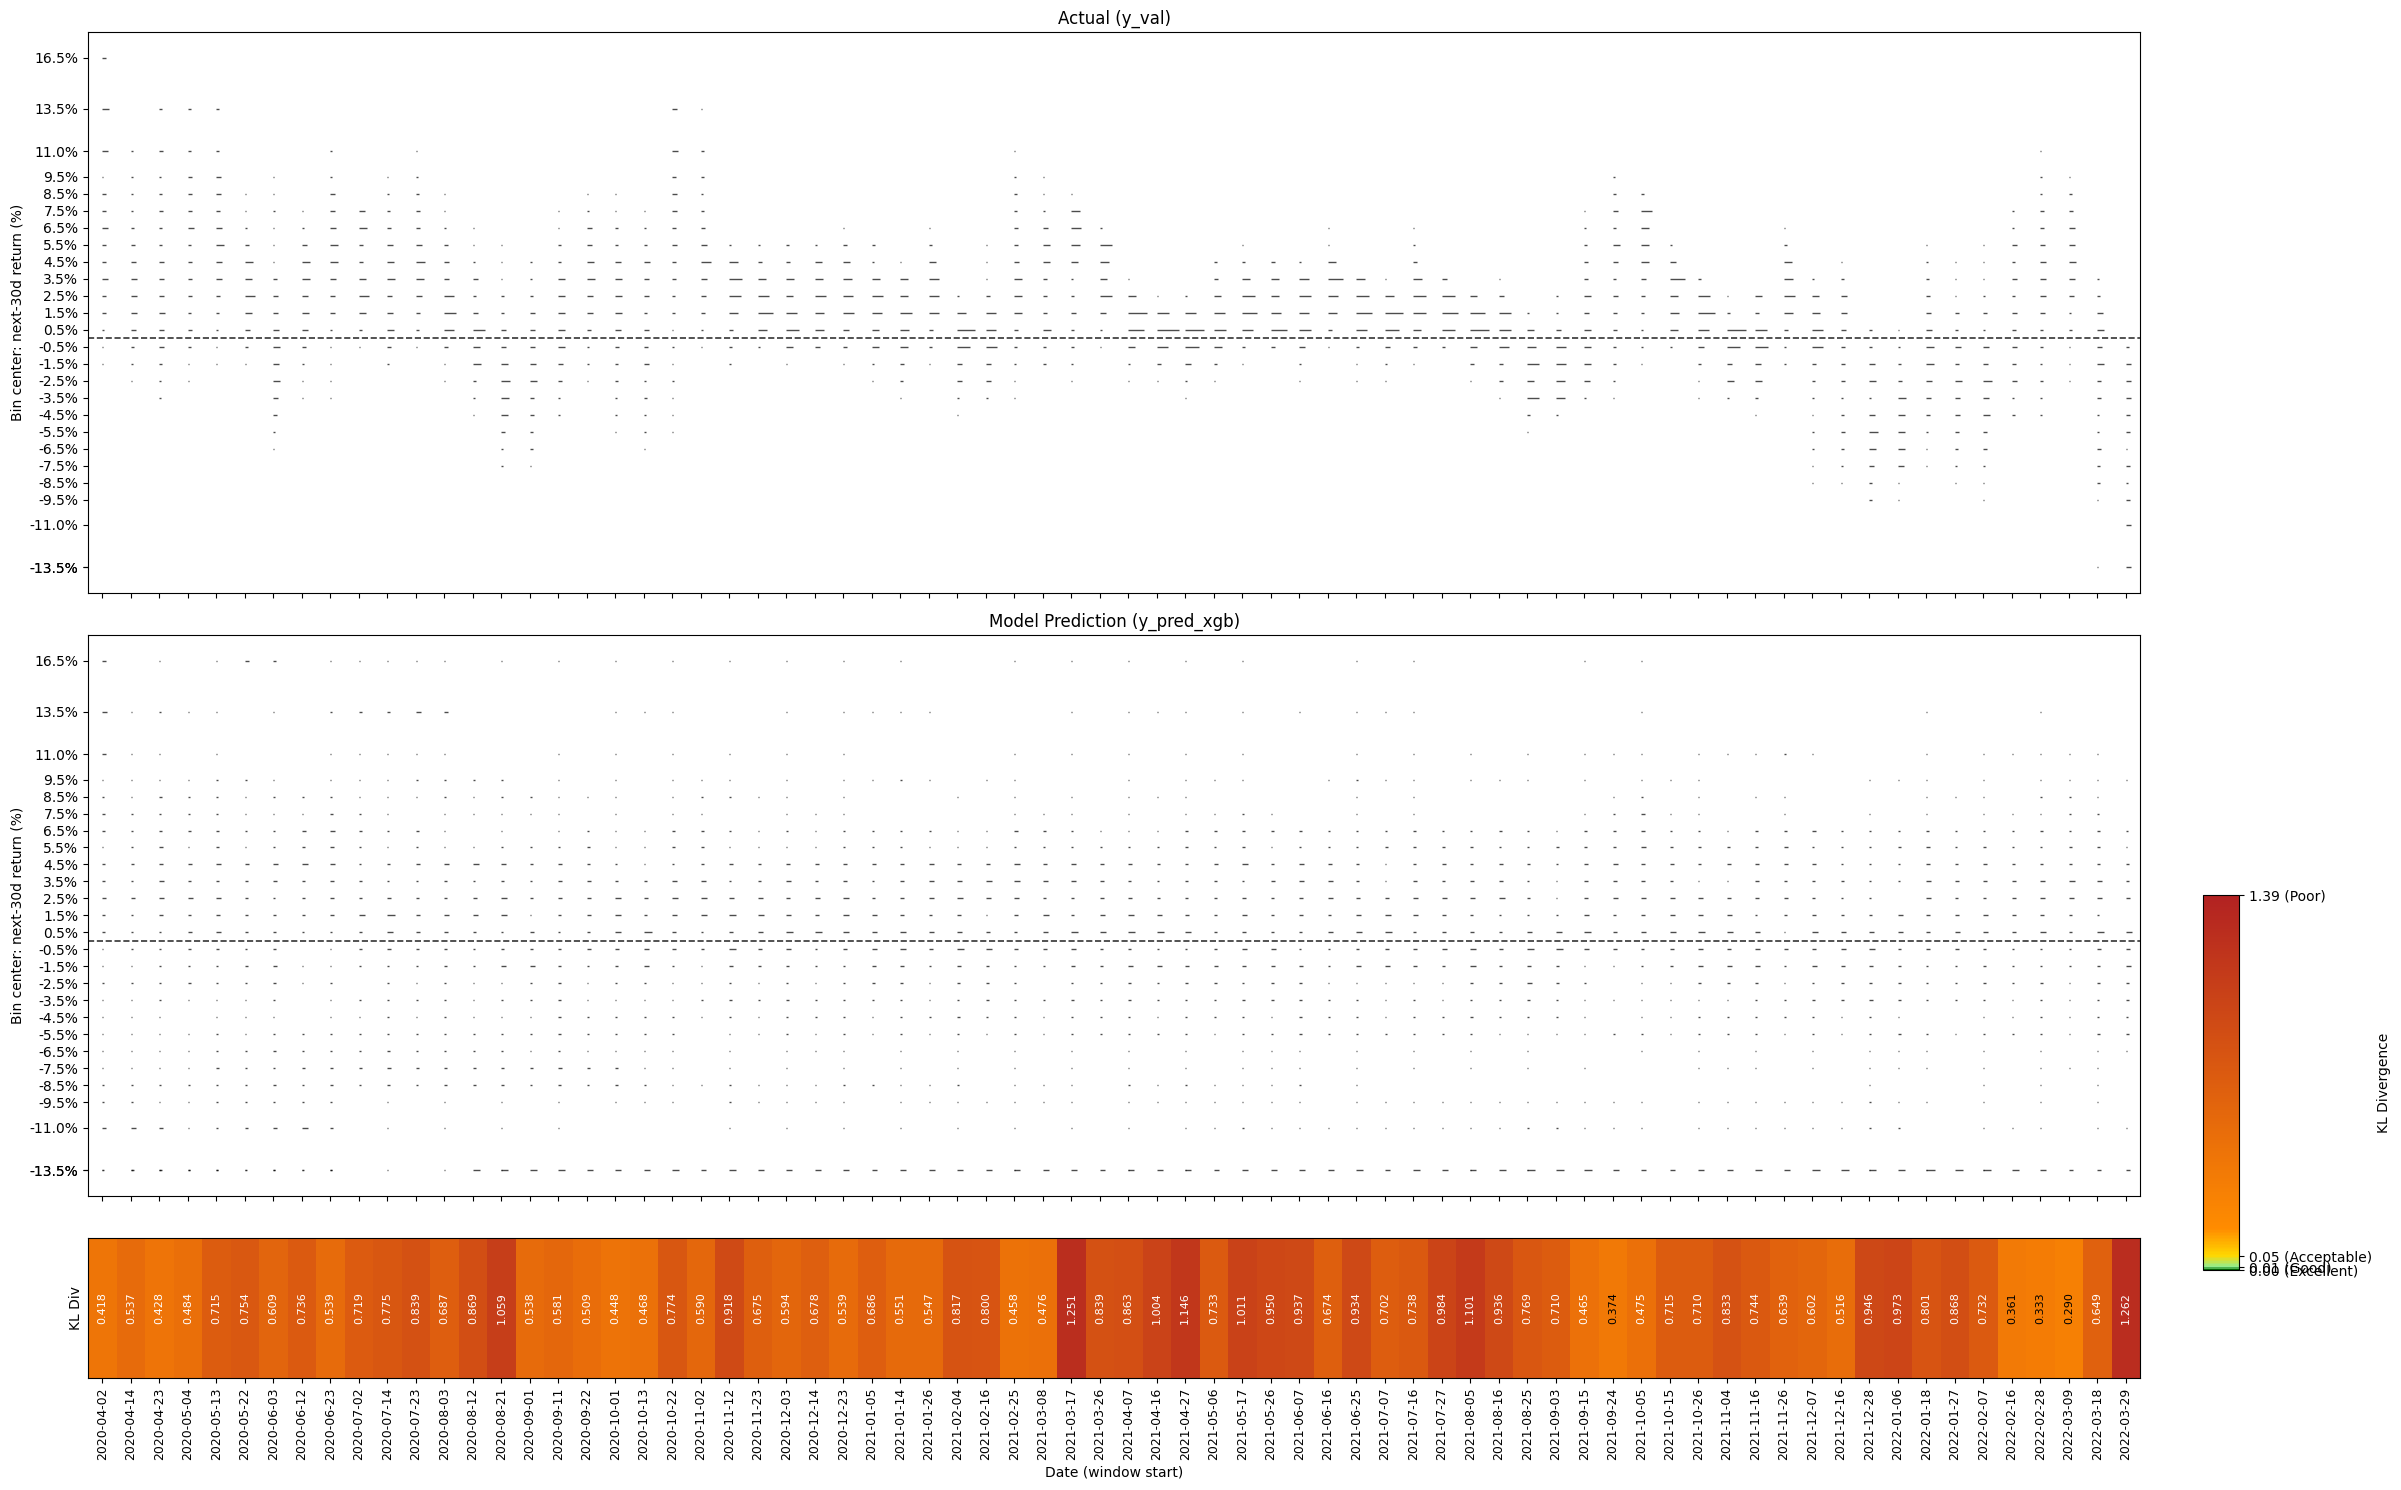

In [140]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import entropy

X_STEP = 7
FIRST_ROW_TO_GRAPH = 500

bin_centers = []
for i in range(len(bin_edges) - 1):
    lower_bound = bin_edges[i]
    upper_bound = bin_edges[i+1]

    if np.isinf(lower_bound) and np.isinf(upper_bound):
        center = 0 # Fallback, should not happen with typical bin_edges
    elif np.isinf(lower_bound):
        center = upper_bound - (upper_bound - bin_edges[i+2]) / 2 if i+2 < len(bin_edges) else upper_bound - 0.01
    elif np.isinf(upper_bound):
        center = lower_bound + (lower_bound - bin_edges[i-1]) / 2 if i-1 >= 0 else lower_bound + 0.01
    else:
        center = 0.5 * (lower_bound + upper_bound)
    bin_centers.append(center)
bin_centers = np.array(bin_centers)


# Actual (y_target)
step = X_STEP
y_target_short = y_val.iloc[:FIRST_ROW_TO_GRAPH]
dates = y_target_short.index
window_dates = [str(dates[i].date()) for i in range(0, len(dates), step)]
histograms_true = []
for i in range(0, len(y_target_short), step):
    window = y_target_short.iloc[i:i+step]
    hist = window.mean(axis=0)
    histograms_true.append(hist.values)
histograms_true = np.array(histograms_true)

# RF predicted (now correctly sourced from y_pred_xgb)
y_pred_rf = y_pred_xgb.iloc[:FIRST_ROW_TO_GRAPH] # This is correct if y_pred_xgb is a DataFrame
histograms_rf = []
for i in range(0, len(y_pred_rf), step): # Use len(y_pred_rf) as it's already short
    hist = y_pred_rf.iloc[i:i+step].mean(axis=0)
    histograms_rf.append(hist.values)
histograms_rf = np.array(histograms_rf)

num_windows = histograms_true.shape[0]
x = np.arange(num_windows)

# KL divergence per window
def safe_entropy(p, q):
    eps = 1e-9
    p_norm = p / np.sum(p)
    q_norm = q / np.sum(q)
    p_clipped = np.clip(p_norm, eps, 1 - eps)
    q_clipped = np.clip(q_norm, eps, 1 - eps)
    return entropy(p_clipped, q_clipped)

kl_values = np.array([safe_entropy(histograms_true[i], histograms_rf[i]) for i in range(num_windows)])

# --- Plotting ---

fig, axes = plt.subplots(
    3, 1, # 3 rows, 1 column
    figsize=(max(14, num_windows // 3), 15), # Increased height for better visibility
    gridspec_kw={"height_ratios": [4, 4, 1]}, # Proportional heights for (Actual, Predicted, KL Div)
    sharex=True # Share X-axis across all subplots for alignment
)

kl_vmin = 0.0
kl_vmax = max(kl_values.max() * 1.1, 0.2) # Set vmax slightly above max observed, or minimum 0.2
kl_norm = mcolors.Normalize(vmin=kl_vmin, vmax=kl_vmax)

# Define custom colormap for KL divergence based on performance
# Now, map actual KL thresholds to normalized positions (0 to 1) using kl_norm
kl_colors_normalized = [
    (kl_norm(0.0), "darkgreen"),      # KL Div 0 (perfect)
    (kl_norm(0.01), "lightgreen"),    # KL Div 0.01 (excellent boundary)
    (kl_norm(0.05), "gold"),          # KL Div 0.05 (good/acceptable boundary)
    (kl_norm(0.15), "darkorange"),    # KL Div 0.15 (warning)
    (kl_norm(max(0.3, kl_vmax)), "firebrick") # KL Div 0.3 or higher, ensure it hits vmax
]
cmap_kl = mcolors.LinearSegmentedColormap.from_list("kl_performance_cmap", kl_colors_normalized)


bar_height = (bin_centers[1] - bin_centers[0]) * 0.55 if len(bin_centers) > 1 else 0.1 # Fallback for single bin
width_scale = 1.8

# Colors for histogram bars (bins: negative, zero, positive)
bin_plot_colors = []
for c in bin_centers:
    if c < 0:
        bin_plot_colors.append('firebrick')
    elif c == 0:
        bin_plot_colors.append('gray')
    else:
        bin_plot_colors.append('forestgreen')

# --- Actual (y_target) - Top Plot ---
for i in range(num_windows):
    axes[0].barh(
        y=bin_centers,
        width=histograms_true[i, :] * width_scale,
        left=i,
        height=bar_height,
        color=bin_plot_colors,
        alpha=0.7,
        edgecolor='k'
    )
axes[0].set_ylabel('Bin center: next-30d return (%)')
axes[0].set_title("Actual (y_val)")
axes[0].set_yticks(bin_centers)
axes[0].set_yticklabels([f"{c*100:.1f}%" for c in bin_centers])
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
axes[0].set_xlim(-0.5, num_windows - 0.5)


# --- Random Forest Prediction (y_pred_xgb) - Middle Plot ---
for i in range(num_windows):
    axes[1].barh(
        y=bin_centers,
        width=histograms_rf[i, :] * width_scale,
        left=i,
        height=bar_height,
        color=bin_plot_colors,
        alpha=0.7,
        edgecolor='k'
    )
axes[1].set_ylabel('Bin center: next-30d return (%)') # Added Y-label for clarity on its own row
axes[1].set_title("Model Prediction (y_pred_xgb)")
axes[1].set_yticks(bin_centers)
axes[1].set_yticklabels([f"{c*100:.1f}%" for c in bin_centers]) # Added Y-tick labels back
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
axes[1].set_xlim(-0.5, num_windows - 0.5)


# --- KL Divergence - Bottom Plot ---
for i in range(num_windows):
    color = cmap_kl(kl_norm(kl_values[i])) # Get color from custom colormap
    axes[2].bar(i, 1, color=color, width=1.0, edgecolor='none')
    # Dynamically set text color for readability
    text_color = 'white' if kl_norm(kl_values[i]) > 0.3 else 'black' # Heuristic for dark/light background
    axes[2].text(i, 0.5, f"{kl_values[i]:.3f}", va='center', ha='center',
                 fontsize=8, color=text_color, rotation=90)

axes[2].set_yticks([]) # No Y-axis ticks for the KL divergence bar
axes[2].set_ylabel("KL Div")
axes[2].set_xlim(-0.5, num_windows - 0.5)
axes[2].set_ylim(0, 1)
axes[2].set_xticks(x)
axes[2].set_xticklabels(window_dates, rotation=90, fontsize=9)
axes[2].set_xlabel('Date (window start)')

# --- Colorbar for KL Divergence ---
# Create a new axis for the colorbar, slightly to the right of the plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.25]) # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap_kl, norm=kl_norm)
sm.set_array([]) # Important for standalone colorbar
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical')
cbar.set_label('KL Divergence')

# Set custom ticks and labels for the colorbar to denote performance zones
cbar.set_ticks([kl_vmin, 0.01, 0.05, kl_vmax])
cbar.set_ticklabels([
    f"{kl_vmin:.2f} (Excellent)",
    "0.01 (Good)",
    "0.05 (Acceptable)",
    f"{kl_vmax:.2f} (Poor)"
])

# Adjust the layout to make room for the colorbar
plt.tight_layout(rect=[0, 0, 0.9, 1]) # Adjust right boundary to prevent colorbar overlap

plt.show()

/tmp/ipykernel_202/2836713114.py:112: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


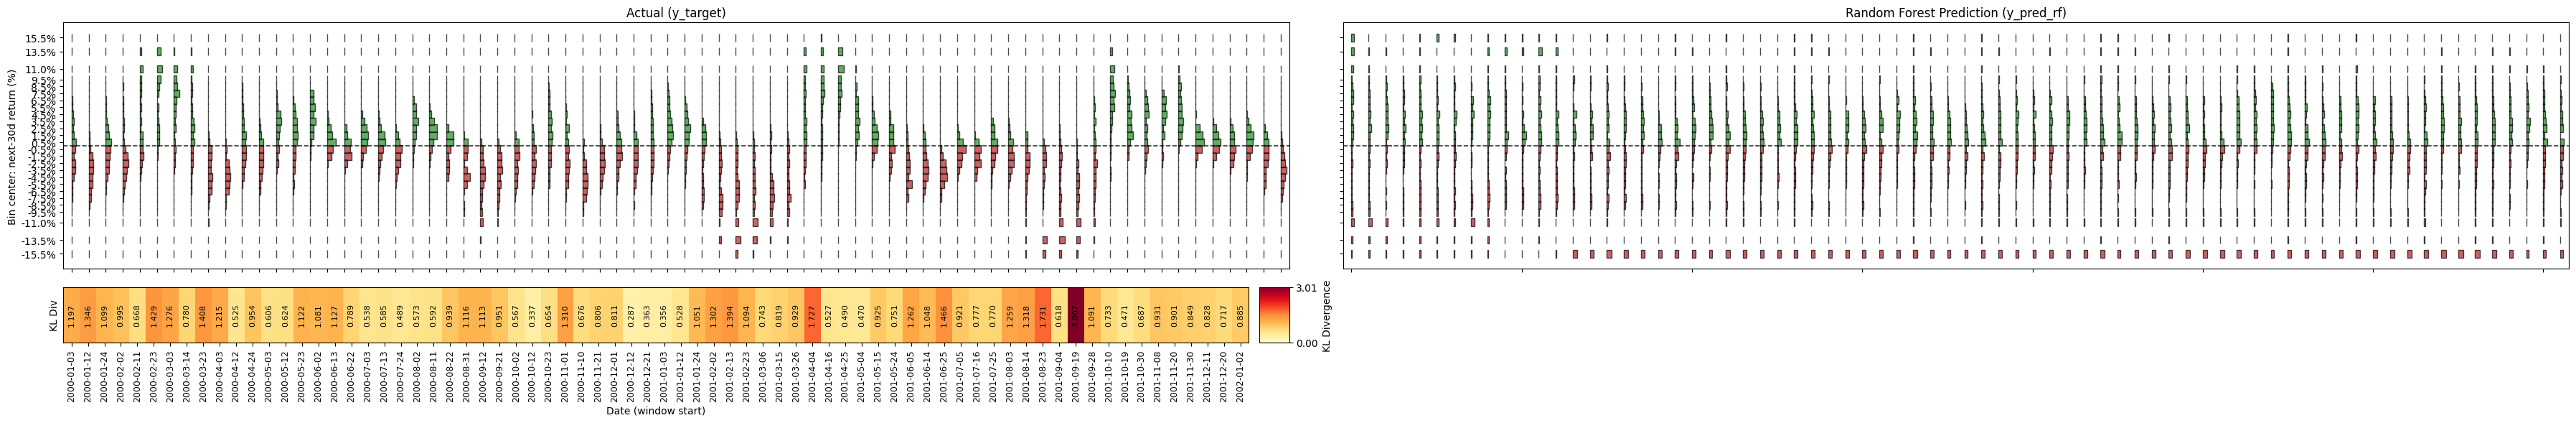

In [141]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import entropy

X_STEP = 7
FIRST_ROW_TO_GRAPH = 500

# Bin centers
bin_centers = []
for i in range(len(bin_edges)-1):
    if np.isinf(bin_edges[i]):
        left = bin_edges[i+1] - 0.01
    else:
        left = bin_edges[i]
    if np.isinf(bin_edges[i+1]):
        right = bin_edges[i] + 0.01
    else:
        right = bin_edges[i+1]
    bin_centers.append(0.5 * (left + right))

# Actual (y_target)
step = X_STEP
y_target_short = y_target_df.iloc[:FIRST_ROW_TO_GRAPH]
dates = y_target_short.index
window_dates = [str(dates[i].date()) for i in range(0, len(dates), step)]
histograms_true = []
for i in range(0, len(y_target_short), step):
    window = y_target_short.iloc[i:i+step]
    hist = window.mean(axis=0)
    histograms_true.append(hist.values)
histograms_true = np.array(histograms_true)

y_pred_rf = y_pred_xgb
# RF predicted
if isinstance(y_pred_rf, str):  # if it's a filename
    y_pred_rf = np.load(y_pred_rf, allow_pickle=True)
y_pred_rf_short = y_pred_rf[:FIRST_ROW_TO_GRAPH]
histograms_rf = []
for i in range(0, len(y_pred_rf_short), step):
    hist = y_pred_rf_short[i:i+step].mean(axis=0)
    histograms_rf.append(hist)
histograms_rf = np.array(histograms_rf)

num_windows = histograms_true.shape[0]
x = np.arange(num_windows)

# KL divergence per window
def safe_entropy(p, q):
    eps = 1e-9
    p = np.clip(p, eps, 1)
    q = np.clip(q, eps, 1)
    return entropy(p, q)

kl_values = np.array([safe_entropy(histograms_true[i], histograms_rf[i]) for i in range(num_windows)])

# -- Plot --
fig, axes = plt.subplots(
    2, 2, figsize=(max(14, num_windows//2), 6),
    gridspec_kw={"height_ratios": [4, 0.9]},
    sharex='col'
)

bar_height = (bin_centers[1] - bin_centers[0]) * 0.55
width_scale = 1.8

colors = []
for c in bin_centers:
    if c < 0:
        colors.append('firebrick')
    elif c == 0:
        colors.append('gray')
    else:
        colors.append('forestgreen')

# LEFT: Actual
for i in range(num_windows):
    axes[0,0].barh(
        y=bin_centers,
        width=histograms_true[i, :] * width_scale,
        left=i,
        height=bar_height,
        color=colors,
        alpha=0.7,
        edgecolor='k'
    )
axes[0,0].set_ylabel('Bin center: next-30d return (%)')
axes[0,0].set_title("Actual (y_target)")
axes[0,0].set_yticks(bin_centers)
axes[0,0].set_yticklabels([f"{c*100:.1f}%" for c in bin_centers])
axes[0,0].axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
axes[0,0].set_xlim(-0.5, num_windows - 0.5)

# RIGHT: RF prediction
for i in range(num_windows):
    axes[0,1].barh(
        y=bin_centers,
        width=histograms_rf[i, :] * width_scale,
        left=i,
        height=bar_height,
        color=colors,
        alpha=0.7,
        edgecolor='k'
    )
axes[0,1].set_title("Random Forest Prediction (y_pred_rf)")
axes[0,1].set_yticks(bin_centers)
axes[0,1].set_yticklabels([])
axes[0,1].axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
axes[0,1].set_xlim(-0.5, num_windows - 0.5)

# -- KL divergence in bottom row, under both panels --
cmap = plt.cm.get_cmap('YlOrRd')
vmin, vmax = 0, max(kl_values.max(), 0.5)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

for i in range(num_windows):
    color = cmap(norm(kl_values[i]))
    axes[1,0].bar(i, 1, color=color, width=1.0, edgecolor='none')
    axes[1,0].text(i, 0.5, f"{kl_values[i]:.3f}", va='center', ha='center', fontsize=8, color='black', rotation=90)
axes[1,0].set_yticks([])
axes[1,0].set_ylabel("KL Div")
axes[1,0].set_xlim(-0.5, num_windows - 0.5)
axes[1,0].set_ylim(0, 1)
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(window_dates, rotation=90, fontsize=9)
axes[1,0].set_xlabel('Date (window start)')

# Empty colorbar only under first panel for clarity
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes('right', size='2.5%', pad=0.15)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('KL Divergence')
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([f"{vmin:.2f}", f"{vmax:.2f}"])

axes[1,1].axis('off')  # right-bottom panel not needed

plt.tight_layout()
plt.show()


In [158]:
reload_utils()
from utils.models import get_sklearn_model, get_nn_model
from utils.train import train_sklearn_model, train_nn_model, log_model_artifact, log_final_metrics, conditionally_encode_labels
from utils.eval import evaluate_model

import mlflow
os.environ["WANDB_BASE_URL"] = "http://wandb:8080"
os.environ["WANDB_DEBUG"] = "true"
os.environ["WANDB_DEBUG_LOG_PATH"] = "/tmp/wandb_debug.log"
import wandb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define model sweep
print("defining sweep")
model_configs = {
    # "random_forest": [
    #     {"n_estimators": n, "max_depth": d, "max_features": f, "min_samples_split": m}
    #     for n in [50, 250]
    #     for d in [None, 10]
    #     for f in ["sqrt", "log2"]
    #     for m in [2, 5]
    # ],
    # "logistic_regression": [
    #     {"penalty": p, "C": c, "solver": "liblinear", "max_iter": 200}
    #     for p in ["l1", "l2"]
    #     for c in [0.01, 0.1, .5]
    # ],

    # "xgboost": [
    #     {"n_estimators": n, "max_depth": d, "learning_rate": lr, "subsample": s, "colsample_bytree": cbt}
    #     for n in [50,200]
    #     for d in [5, 7]
    #     for lr in [0.005, 0.01,.05]
    #     for s in [0.8, 1.0]
    #     for cbt in [0.8, 1.0]
    # ],

    # "lightgbm": [
    #     {"n_estimators": n, "max_depth": d, "learning_rate": lr, "num_leaves": nl, "min_child_samples": mcs}
    #     for n in [100, 200]
    #     for d in [-1, 10]
    #     for lr in [0.01, 0.1]
    #     for nl in [31, 50]
    #     for mcs in [10, 20]
    # ],
    # "svm": [
    #     {"C": c, "kernel": k, "gamma": g}
    #     for c in [0.1, 1.0, 10.0]
    #     for k in ["linear", "rbf", "poly"]
    #     for g in ["scale", "auto"]
    # ],

    # "naive_bayes": [
    #     {"var_smoothing": vs}
    #     for vs in [1e-9, 1e-8, 1e-7]
    # ],

    # "knn": [
    #     {"n_neighbors": k, "weights": w, "metric": m}
    #     for k in [ 5, 7]
    #     for w in ["uniform", "distance"]
    #     for m in ["euclidean", "manhattan"]
    # ],
    "neural_net": [
        {
            "model_type": mt,
            "hidden": h,
            "dropout": d,
            "activation": act,
            "batch_norm": bn,
            "lr": lr,
            "num_layers": nl
        }
        for mt in ["mlp", "lstm", "cnn"]
        for h in [32, 64,96]
        for d in [0.0,.1, 0.3]
        for act in ["relu", "tanh"]
        for bn in [False, True]
        for lr in [.0005, 0.0001, .005, 0.001, .05,.01]
        for nl in [1, 2, 3,4]
    ],
}

mlflow.set_experiment(f"kaggle_{local_dataset_name}")
print("starting experiments")
# Loop over each model and its hyperparam
for model_name, config_list in model_configs.items():
    for params in config_list:
        # Terminate any already running experiments (MLflow and W&B)
        if mlflow.active_run() is not None:
            mlflow.end_run()
        wandb.finish()
        # === Init Experiment | MLflow and W&B ===
        run_name = f"{model_name}_{params}"
        run = mlflow.start_run(run_name=run_name)
        mlflow.log_param("model_name", model_name)
        mlflow.log_params(params)
        mlflow.log_param("task_type", task_type)
        mlflow.log_param("perf_eval_metric", perf_eval_metric)
        # mlflow.log_param("etl_version", etl_result['etl_version'])
        # mlflow.log_param("etl_description", etl_result['etl_description'])
        print("Started MLflow run:", run.info.run_id)
        wandb.init(
            project=f"kaggle_{local_dataset_name}",
            name=run_name,
            config={
                **params,
                "model_name": model_name,
                "task_type": task_type,
                "perf_eval_metric": perf_eval_metric,
                # "etl_version": etl_result['etl_version'],
                # "etl_description": etl_result['etl_description']
            }
        )
        # === Train ===
        if model_name == "neural_net":
            output_dim = y_train.nunique() if task_type == "multiclass_classification" else y_train.shape[1]
            model, lr = get_nn_model(X_train.shape[1], output_dim=output_dim, **params)
            model, y_pred = train_nn_model(
                model, X_train, y_train, X_val, y_val,
                epochs=50,
                lr = lr,
                task_type=task_type,
                eval_metric_name=eval_metric_name,
                eval_metric_fn=eval_metric_fn,
                bin_centers=bin_centers,
            )
            print("✅ Finished training neural net")

        else:
            model = get_sklearn_model(model_name, task_type, **params)
            trained_model, y_pred = train_sklearn_model(
                model, X_train, y_train, X_val, y_val,
                task_type=task_type,
            )
            print("✅ Finished training sklearn model")

        # === Evaluate & log ===
        eval_metrics = evaluate_model(y_val, y_pred, task_type, eval_metric_name=eval_metric_name, eval_metric_fn=eval_metric_fn, bin_centers=bin_centers)

        log_final_metrics(eval_metrics)
        # commented out to reduced write2dis
        # log_model_artifact(trained_model, model_name, framework="torch" if model_name == "neural_net" else "sklearn")

        # === End Experiment | MLflow and W&B ===
        mlflow.end_run()
        wandb.finish()


🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda,utils.train, utils.models, utils.eval, utils.submission
defining sweep
starting experiments
🏃 View run neural_net_{'model_type': 'mlp', 'hidden': 32, 'dropout': 0.0, 'activation': 'relu', 'batch_norm': False, 'lr': 0.0005, 'num_layers': 1} at: http://mlflow:5000/#/experiments/1/runs/cd8a7500c2604056997a940d8d04eb89
🧪 View experiment at: http://mlflow:5000/#/experiments/1


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
epoch,49
train_loss,nan


Started MLflow run: e569db6f166b462591f0c4f1d4e117e1


Using device: cpu
✅ Finished training neural net
🏃 View run neural_net_{'model_type': 'mlp', 'hidden': 32, 'dropout': 0.0, 'activation': 'relu', 'batch_norm': False, 'lr': 0.0005, 'num_layers': 1} at: http://mlflow:5000/#/experiments/1/runs/e569db6f166b462591f0c4f1d4e117e1
🧪 View experiment at: http://mlflow:5000/#/experiments/1


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
epoch,49
kl_divergence,nan
l1_loss_overall,nan
l2_loss_overall,nan
train_loss,nan


Started MLflow run: b7e0d8777f154ece81d71e2ee4ae9791


Using device: cpu


KeyboardInterrupt: 